In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.corpus import stopwords
#nltk.download('averaged_perceptron_tagger')

from textblob import TextBlob
from textblob import Word

import codecs

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from helper import *

Using TensorFlow backend.


# Introduction

# Data Cleaning, Feature Engineering, and EDA

## Data Cleaning

### Review Data

We will start by loading our Yelp Academic dataset into a pandas dataframe. 

In [3]:
review_df = pd.read_csv('yelp_academic_dataset_review.csv')

In [4]:
review_df.head()

user_id  \
0  b'hG7b0MtEbXx5QzbzE6C_VA'   
1  b'yXQM5uF2jS6es16SJzNHfg'   
2  b'n6-Gk65cPZL6Uz8qRm3NYw'   
3  b'dacAIZ6fTM6mqwW5uxkskg'   
4  b'ssoyf2_x0EQMed6fgHeMyQ'   

                                                text                    date  \
0  b'Total bill for this horrible service? Over $...  b'2013-05-07 04:34:36'   
1  b"I *adore* Travis at the Hard Rock's new Kell...  b'2017-01-14 21:30:33'   
2  b"I have to say that this office really has it...  b'2016-11-09 20:09:03'   
3  b"Went in for a lunch. Steak sandwich was deli...  b'2018-01-09 20:56:38'   
4  b'Today was my second out of three sessions I ...  b'2018-01-30 23:07:38'   

                   review_id                business_id  funny  cool  useful  \
0  b'Q1sbwvVQXV2734tPgoKj4Q'  b'ujmEBvifdJM6h6RLv4wQIg'      1     0       6   
1  b'GJXCdrto3ASJOqKeVWPi6Q'  b'NZnhc2sEQy3RmzKTZnqtwQ'      0     0       0   
2  b'2TzJjDVDEuAW6MR5Vuc1ug'  b'WTqjgwHlXbSFevF32_DJVw'      0     0       3   
3  b'yi0R0Ugj_xUx_Nek0-_Qig'  b'ikCg8xy5JIg_NGPx-MSIDA'      0     0       0   
4  b'11a8sVPMUFtaC7_ABRkmtw'  b'b1b1eb3uo-w561D0ZfCEiQ'      0     0       7   

   stars  
0    1.0  
1    5.0  
2    5.0  
3    5.0  
4    1.0

We are only interested in a select few of these columns so we will narrow down our dataframe to contain only 'text', 'business_id', 'useful', and 'stars'.

In [5]:
review_df = review_df[['text', 'business_id', 'useful', 'stars']]

In [6]:
# sanity check
review_df.head()

text  \
0  b'Total bill for this horrible service? Over $...   
1  b"I *adore* Travis at the Hard Rock's new Kell...   
2  b"I have to say that this office really has it...   
3  b"Went in for a lunch. Steak sandwich was deli...   
4  b'Today was my second out of three sessions I ...   

                 business_id  useful  stars  
0  b'ujmEBvifdJM6h6RLv4wQIg'       6    1.0  
1  b'NZnhc2sEQy3RmzKTZnqtwQ'       0    5.0  
2  b'WTqjgwHlXbSFevF32_DJVw'       3    5.0  
3  b'ikCg8xy5JIg_NGPx-MSIDA'       0    5.0  
4  b'b1b1eb3uo-w561D0ZfCEiQ'       7    1.0

We notice here that our 'business_id' and 'text' columns contain a "b" in front of each string along with quotation marks. We will now remove those. 

In [7]:
# experiment
review_df['business_id'][0][2:-1]

'ujmEBvifdJM6h6RLv4wQIg'

In [8]:
# apply using lambda function
review_df['business_id'] = review_df['business_id'].apply(lambda x: x[2:-1])

In [9]:
review_df

text  \
0        b'Total bill for this horrible service? Over $...   
1        b"I *adore* Travis at the Hard Rock's new Kell...   
2        b"I have to say that this office really has it...   
3        b"Went in for a lunch. Steak sandwich was deli...   
4        b'Today was my second out of three sessions I ...   
...                                                    ...   
6685895  b'I have been coming here for years and this p...   
6685896  b"I think this owner and the owner of Amy's Ba...   
6685897  b'Off the grid Mexican in Vegas. Very tasty, q...   
6685898  b"We hired Taco Naco to cater our family party...   
6685899  b"Having just come back from Hawaii a few mont...   

                    business_id  useful  stars  
0        ujmEBvifdJM6h6RLv4wQIg       6    1.0  
1        NZnhc2sEQy3RmzKTZnqtwQ       0    5.0  
2        WTqjgwHlXbSFevF32_DJVw       3    5.0  
3        ikCg8xy5JIg_NGPx-MSIDA       0    5.0  
4        b1b1eb3uo-w561D0ZfCEiQ       7    1.0  
...                         ...     ...    ...  
6685895  RXBFk3tVBxiTf3uOt9KExQ       1    5.0  
6685896  yA6dKNm_zl1ucZCnwW8ZCg      13    1.0  
6685897  a192hdM0_UVCYLwPJv1Qwg       0    5.0  
6685898  kOo4ZY2UQAX4j312mzQ8mA       1    5.0  
6685899  PkqN5st3zZ_Xce_5QlBtNQ       2    3.0  

[6685900 rows x 4 columns]

### Business Details

Next we will import the business details so that we may add the category of each business to our review dataframe.

In [10]:
business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True)

In [11]:
business_df.head()

business_id                      name  \
0  f9NumwFMBDn751xgFiRbNA  The Range At Lake Norman   
1  Yzvjg0SayhoZgCljUJRF9Q         Carlos Santo, NMD   
2  XNoUzKckATkOD1hP6vghZg                   Felinus   
3  6OAZjbxqM5ol29BuHsil3w      Nevada House of Hose   
4  51M2Kk903DFYI6gnB5I6SQ   USE MY GUY SERVICES LLC   

                     address             city state postal_code   latitude  \
0            10913 Bailey Rd        Cornelius    NC       28031  35.462724   
1  8880 E Via Linda, Ste 107       Scottsdale    AZ       85258  33.569404   
2      3554 Rue Notre-Dame O         Montreal    QC     H4C 1P4  45.479984   
3             1015 Sharp Cir  North Las Vegas    NV       89030  36.219728   
4         4827 E Downing Cir             Mesa    AZ       85205  33.428065   

    longitude  stars  review_count  is_open  \
0  -80.852612    3.5            36        1   
1 -111.890264    5.0             4        1   
2  -73.580070    5.0             5        1   
3 -115.127725    2.5             3        0   
4 -111.726648    4.5            26        1   

                                          attributes  \
0  {'BusinessAcceptsCreditCards': 'True', 'BikePa...   
1  {'GoodForKids': 'True', 'ByAppointmentOnly': '...   
2                                               None   
3  {'BusinessAcceptsCreditCards': 'True', 'ByAppo...   
4  {'BusinessAcceptsCreditCards': 'True', 'ByAppo...   

                                          categories  \
0  Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...   
1  Health & Medical, Fitness & Instruction, Yoga,...   
2                   Pets, Pet Services, Pet Groomers   
3  Hardware Stores, Home Services, Building Suppl...   
4  Home Services, Plumbing, Electricians, Handyma...   

                                               hours  
0  {'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...  
1                                               None  
2                                               None  
3  {'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ...  
4  {'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...

As we can see in the dataframe head our businesses come from a wealth of categories. The scope of our application at this point in time is limited to coffee shops and women's clothing boutiques. Thus, we want to train models based on the category of business we will be building our application on. We will be filtering for businesses which are either related to coffee shops (for example, "Coffee & Tea") or women's boutiques (for example, "Women's Clothing", "Home Decor", "Gift Shops").

Our first step in doing this will be to create a new dataframe where we "split" the category column and then "stack" the results so that each business / category combination is a unique row. 

In [12]:
# "split" category column and "stack rows"
business_categories = business_df.set_index('business_id').categories.str.split(',', expand=True).stack().reset_index('business_id')
# rename columns
business_categories.columns = ['business_id', 'category']
# check head
business_categories.head(20)

business_id                category
0  f9NumwFMBDn751xgFiRbNA             Active Life
1  f9NumwFMBDn751xgFiRbNA        Gun/Rifle Ranges
2  f9NumwFMBDn751xgFiRbNA             Guns & Ammo
3  f9NumwFMBDn751xgFiRbNA                Shopping
0  Yzvjg0SayhoZgCljUJRF9Q        Health & Medical
1  Yzvjg0SayhoZgCljUJRF9Q   Fitness & Instruction
2  Yzvjg0SayhoZgCljUJRF9Q                    Yoga
3  Yzvjg0SayhoZgCljUJRF9Q             Active Life
4  Yzvjg0SayhoZgCljUJRF9Q                 Pilates
0  XNoUzKckATkOD1hP6vghZg                    Pets
1  XNoUzKckATkOD1hP6vghZg            Pet Services
2  XNoUzKckATkOD1hP6vghZg            Pet Groomers
0  6OAZjbxqM5ol29BuHsil3w         Hardware Stores
1  6OAZjbxqM5ol29BuHsil3w           Home Services
2  6OAZjbxqM5ol29BuHsil3w       Building Supplies
3  6OAZjbxqM5ol29BuHsil3w           Home & Garden
4  6OAZjbxqM5ol29BuHsil3w                Shopping
0  51M2Kk903DFYI6gnB5I6SQ           Home Services
1  51M2Kk903DFYI6gnB5I6SQ                Plumbing
2  51M2Kk903DFYI6gnB5I6SQ            Electricians

Now let's check to see the unique categories available. 

In [13]:
unique_categories = list(business_categories.category.unique())

In [14]:
sorted(unique_categories, reverse=True)

['Zoos',
 'Ziplining',
 'Yoga',
 'Yelp Events',
 'Wraps',
 'Workers Compensation Law',
 "Women's Clothing",
 'Wineries',
 'Wine Tours',
 'Wine Tasting Room',
 'Wine Tasting Classes',
 'Wine Bars',
 'Windshield Installation & Repair',
 'Windows Installation',
 'Window Washing',
 'Wills',
 'Wildlife Control',
 'Wigs',
 'Wholesalers',
 'Wholesale Stores',
 'Whiskey Bars',
 'Wheel & Rim Repair',
 'Weight Loss Centers',
 'Wedding Planning',
 'Wedding Chapels',
 'Web Design',
 'Waxing',
 'Waterproofing',
 'Water Suppliers',
 'Water Stores',
 'Water Purification Services',
 'Water Parks',
 'Water Heater Installation/Repair',
 'Water Delivery',
 'Watches',
 'Watch Repair',
 'Wallpapering',
 'Walking Tours',
 'Walk-in Clinics',
 'Waldorf Schools',
 'Waffles',
 'Vocational & Technical School',
 'Vitamins & Supplements',
 'Virtual Reality Centers',
 'Vinyl Records',
 'Vietnamese',
 'Videos & Video Game Rental',
 'Videographers',
 'Video/Film Production',
 'Video Game Stores',
 'Veterinarians',
 '

Using the sorted list above we can compile category lists associated with each of our broader categories and create dataframes for each category. 

In [15]:
coffee_categories = ['Coffee & Tea', 'Coffeeshops']
shopping_categories = ['Home Decor', 'Gift Shops', "Women's Clothing", 'Thrift Stores', 'Shoe Stores']

In [16]:
# create coffee shops dataframe
coffee_shops = business_categories[business_categories['category'].isin(coffee_categories)]

In [17]:
# check head
coffee_shops.head()

business_id      category
0  _xOeoXfPUQTNlUAhXl32ug  Coffee & Tea
0  8Hvp1tYKiQbBgGIwkCRK5g  Coffee & Tea
0  NLaK58WvlNQdUunSIkt-jA  Coffee & Tea
0  YHE1PS0mhFbwKJm8iJpcuQ  Coffee & Tea
0  1aVqiz43klXaFJUUx0H5fw  Coffee & Tea

In [18]:
# remove duplicates
coffee_shops = coffee_shops.drop_duplicates(subset='business_id')

We will now create another dataframe for our boutique shops category. 

In [19]:
# create boutique shops dataframe
boutique_shops = business_categories[business_categories['category'].isin(shopping_categories)]
# check head
boutique_shops.head()

business_id          category
0  ANANgb9e-BfpOXjDTv_H6Q     Thrift Stores
0  UXgaUOaXsplzZeALU5ytsA  Women's Clothing
0  VTOvXMJvmG1LNmYMdQ3eNw  Women's Clothing
0  q8967a_rhSOwVI0olMNJqw  Women's Clothing
0  beHPviKDbCUJD6L20S3JzA       Shoe Stores

### Merge Dataframes

We will now merge our review and business details dataframes so that the resulting two dataframes will be review data for only the categories which we are interested in. 

In [20]:
# first create coffee_reviews_df
coffee_reviews_df = review_df.merge(coffee_shops, left_on='business_id', right_on='business_id')

In [21]:
coffee_reviews_df.head()

text             business_id  \
0  b"Yes... the Boba Tea explosion is in full for...  1HD5iUUfVJDbfEBIn9yVhw   
1  b'I used to come here a lot. It was the best b...  1HD5iUUfVJDbfEBIn9yVhw   
2  b"This place brings me back to the boba in Cal...  1HD5iUUfVJDbfEBIn9yVhw   
3  b"Really, really, really good milk tea boba! T...  1HD5iUUfVJDbfEBIn9yVhw   
4  b'Affordable and delicious bubble tea!!\n\nI w...  1HD5iUUfVJDbfEBIn9yVhw   

   useful  stars      category  
0      11    5.0  Coffee & Tea  
1       0    3.0  Coffee & Tea  
2       0    5.0  Coffee & Tea  
3       0    5.0  Coffee & Tea  
4       1    5.0  Coffee & Tea

Just as we did for the 'business_id' column we will remove the 'b' and quoatation marks from the review text.

In [22]:
# remove 'b' and quotation marks
coffee_reviews_df['text'] = coffee_reviews_df['text'].apply(lambda x: x[2:-1])

In [23]:
# check head
coffee_reviews_df.head()

text             business_id  \
0  Yes... the Boba Tea explosion is in full force...  1HD5iUUfVJDbfEBIn9yVhw   
1  I used to come here a lot. It was the best bob...  1HD5iUUfVJDbfEBIn9yVhw   
2  This place brings me back to the boba in Cali ...  1HD5iUUfVJDbfEBIn9yVhw   
3  Really, really, really good milk tea boba! The...  1HD5iUUfVJDbfEBIn9yVhw   
4  Affordable and delicious bubble tea!!\n\nI was...  1HD5iUUfVJDbfEBIn9yVhw   

   useful  stars      category  
0      11    5.0  Coffee & Tea  
1       0    3.0  Coffee & Tea  
2       0    5.0  Coffee & Tea  
3       0    5.0  Coffee & Tea  
4       1    5.0  Coffee & Tea

We shall now create the boutique_reviews_df using the same methodology as above. 

In [24]:
# first create boutique_reviews_df
boutique_reviews_df = review_df.merge(boutique_shops, left_on='business_id', right_on='business_id')

In [25]:
# remove 'b' and quotation marks
boutique_reviews_df['text'] = boutique_reviews_df['text'].apply(lambda x: x[2:-1])

In [26]:
boutique_reviews_df.head(20)

text             business_id  \
0   Right off the bat, I need to tell you that I l...  LWxSTjV6zybxIZKkSK3SNQ   
1   RIP-OFF ALERT!!!!! Went for a little school cl...  LWxSTjV6zybxIZKkSK3SNQ   
2   Headline: Savers Saves Summerlin!\n\nIn the gr...  LWxSTjV6zybxIZKkSK3SNQ   
3   This place was not great. Quality of items not...  LWxSTjV6zybxIZKkSK3SNQ   
4   I have been to this Savers location, a few tim...  LWxSTjV6zybxIZKkSK3SNQ   
5   Very large thrift store, worth a look.  Defini...  LWxSTjV6zybxIZKkSK3SNQ   
6   I'll start by stating I am an avid second-hand...  LWxSTjV6zybxIZKkSK3SNQ   
7   Rude people should not be in charge of taking ...  LWxSTjV6zybxIZKkSK3SNQ   
8   They over price there shoes and clothes 9.99 a...  LWxSTjV6zybxIZKkSK3SNQ   
9   I like this store because of Carolyn. She is a...  LWxSTjV6zybxIZKkSK3SNQ   
10  Are you kidding me?? They call this a "thrift"...  LWxSTjV6zybxIZKkSK3SNQ   
11  I\'ve been visiting this savers along with two...  LWxSTjV6zybxIZKkSK3SNQ   
12  You are more likely to find an abandoned poopy...  LWxSTjV6zybxIZKkSK3SNQ   
13  Do not apply to work here ... I worked here 8 ...  LWxSTjV6zybxIZKkSK3SNQ   
14  Okay, first things first, the smell. You walk ...  LWxSTjV6zybxIZKkSK3SNQ   
15  It's not often if ever that you find a Jimi He...  LWxSTjV6zybxIZKkSK3SNQ   
16  I love the place and I come at least once a mo...  LWxSTjV6zybxIZKkSK3SNQ   
17  Good finds but customer service was AWFUL. Too...  LWxSTjV6zybxIZKkSK3SNQ   
18  I've been a fan of Savers for a while, but I'm...  LWxSTjV6zybxIZKkSK3SNQ   
19  Don't get me wrong, as I'm a huge fan of Saver...  LWxSTjV6zybxIZKkSK3SNQ   

    useful  stars       category  
0        2    4.0  Thrift Stores  
1        3    1.0  Thrift Stores  
2        0    4.0  Thrift Stores  
3        4    2.0  Thrift Stores  
4        2    2.0  Thrift Stores  
5        1    3.0  Thrift Stores  
6        1    4.0  Thrift Stores  
7        0    1.0  Thrift Stores  
8        1    1.0  Thrift Stores  
9        0    4.0  Thrift Stores  
10       0    1.0  Thrift Stores  
11       1    1.0  Thrift Stores  
12      10    1.0  Thrift Stores  
13       6    1.0  Thrift Stores  
14       1    4.0  Thrift Stores  
15       3    5.0  Thrift Stores  
16       0    3.0  Thrift Stores  
17       0    1.0  Thrift Stores  
18       0    4.0  Thrift Stores  
19       1    2.0  Thrift Stores

In [27]:
# create list of review dataframes to iterate over
review_dataframes = [boutique_reviews_df, coffee_reviews_df]

As we noticed later in our project, many of these reviews contained \n new line characters which should be removed and replaced with simple spaces. We can do that for both of our dataframes really quick. 

In [28]:
for df in review_dataframes:
    df['text'] = df['text'].apply(lambda x: x.replace("\\n", " "))

## Feature Engineering

Now that we've cleaned and conglomerated our data to the minimum extent, we'd like to begin engineering some features based on sentence structure which could help predict the helpfulness of a review. Potential features include:

1. Number of words in review (excluding stop words)
2. Number of unique words (excluding stop words)
3. Count of each specific part-of-speech

To start, we will use the NLTK library to write a function which will tokenize and POS tag each review. From here we can count the number of verbs, nouns, adverbs, and adjectives in each sentence. 

### POS Tag Counts

In [29]:
# define pos_tagger function
def pos_tagger(text):
    # tokenize words and tag POS in one line
    pos_tokens = pos_tag(word_tokenize(text))
    # create Counter object for count of each POS tag
    count = Counter([j for i,j in pos_tokens])
    return count

In [30]:
# apply the new function to both of our review dataframes
for df in review_dataframes:
    df['POS_tag_counts'] = df['text'].apply(pos_tagger)

In [31]:
# check results.. looks good
coffee_reviews_df.head()

text             business_id  \
0  Yes... the Boba Tea explosion is in full force...  1HD5iUUfVJDbfEBIn9yVhw   
1  I used to come here a lot. It was the best bob...  1HD5iUUfVJDbfEBIn9yVhw   
2  This place brings me back to the boba in Cali ...  1HD5iUUfVJDbfEBIn9yVhw   
3  Really, really, really good milk tea boba! The...  1HD5iUUfVJDbfEBIn9yVhw   
4  Affordable and delicious bubble tea!!  I was s...  1HD5iUUfVJDbfEBIn9yVhw   

   useful  stars      category  \
0      11    5.0  Coffee & Tea   
1       0    3.0  Coffee & Tea   
2       0    5.0  Coffee & Tea   
3       0    5.0  Coffee & Tea   
4       1    5.0  Coffee & Tea   

                                      POS_tag_counts  
0  {'UH': 1, ':': 1, 'DT': 18, 'NNP': 20, 'NN': 3...  
1  {'PRP': 5, 'VBD': 3, 'TO': 1, 'VB': 2, 'RB': 7...  
2  {'DT': 6, 'NN': 9, 'VBZ': 3, 'PRP': 4, 'RB': 1...  
3  {'RB': 3, ',': 2, 'JJ': 2, 'NN': 5, '.': 4, 'D...  
4  {'JJ': 16, 'CC': 6, 'NN': 16, '.': 11, 'PRP': ...

Great. Now we can create a column for each POS tag listed below and add the counts. 

<img src="pos_tags.png">

In [32]:
# determiner, preposition/subordinating conjunction, adjective, noun, proper noun
# DT', 'IN', 'JJ', 'NN', 'NNP'

In [33]:
# create list of all possible parts of speech tags
pos_tags= ['CC','CD','DT','EX','FW','IN','JJ','JJR','JJS','LS','MD','NN','NNS','NNP','NNPS','PDT','POS','PRP','PRP$',
'RB','RBR','RBS','RP','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']

In [34]:
coffee_reviews_df['POS_tag_counts'][0]['WP$']

0

We can now iterate through each dataframe and add a column for each POS tag with the count of of the parts-of-speech in each review.   

In [35]:
# loop through each dataframe and each pos tag and add a column for pos tag count
for df in review_dataframes:
    for tag in pos_tags:
        # use lambda function to read Counter (dictionary) object in 'POS_tag_counts' column
        df[tag] = df['POS_tag_counts'].apply(lambda x: x[tag])

In [36]:
# sanity check
coffee_reviews_df.head()

text             business_id  \
0  Yes... the Boba Tea explosion is in full force...  1HD5iUUfVJDbfEBIn9yVhw   
1  I used to come here a lot. It was the best bob...  1HD5iUUfVJDbfEBIn9yVhw   
2  This place brings me back to the boba in Cali ...  1HD5iUUfVJDbfEBIn9yVhw   
3  Really, really, really good milk tea boba! The...  1HD5iUUfVJDbfEBIn9yVhw   
4  Affordable and delicious bubble tea!!  I was s...  1HD5iUUfVJDbfEBIn9yVhw   

   useful  stars      category  \
0      11    5.0  Coffee & Tea   
1       0    3.0  Coffee & Tea   
2       0    5.0  Coffee & Tea   
3       0    5.0  Coffee & Tea   
4       1    5.0  Coffee & Tea   

                                      POS_tag_counts  CC  CD  DT  EX  ...  VB  \
0  {'UH': 1, ':': 1, 'DT': 18, 'NNP': 20, 'NN': 3...   7   1  18   0  ...   5   
1  {'PRP': 5, 'VBD': 3, 'TO': 1, 'VB': 2, 'RB': 7...   5   0   7   1  ...   2   
2  {'DT': 6, 'NN': 9, 'VBZ': 3, 'PRP': 4, 'RB': 1...   3   1   6   1  ...   4   
3  {'RB': 3, ',': 2, 'JJ': 2, 'NN': 5, '.': 4, 'D...   1   0   4   0  ...   0   
4  {'JJ': 16, 'CC': 6, 'NN': 16, '.': 11, 'PRP': ...   6   0  10   0  ...   6   

   VBD  VBG  VBN  VBP  VBZ  WDT  WP  WP$  WRB  
0    6    1    2   11    6    1   2    0    0  
1    3    0    0    3    2    0   0    0    0  
2    0    1    0    3    3    0   0    0    0  
3    0    0    1    2    1    0   0    0    0  
4    6    0    2    2    4    0   0    0    0  

[5 rows x 41 columns]

### Word Counts

Now that we have all of our POS tags, we'd also like to add columns which will simply give us the number of words (total and unique) in each review, excluding stop words. To do this we will first create a column which features our reviews tokenized with punctuation and stop words removed. 

In [37]:
# define tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# define stop words
stop_words = set(stopwords.words('english'))

# define function to tokenize reviews and remove stop words and punctuation
def tokenize_review(review):
    # make all characters lowercase
    review = review.lower()
    # create tokens, use regex to remove all punctuation
    tokens = tokenizer.tokenize(review)
    # remove stopwords
    clean_tokens = [token for token in tokens if not token in stop_words]
    return clean_tokens

In [38]:
# test function
tokenize_review("It's so fluffy! I want to die.")

['fluffy', 'want', 'die']

In [39]:
# add column with non-stop word tokens for each review
for df in review_dataframes:
    df['cleaned_text_tokens'] = df['text'].apply(tokenize_review)

In [40]:
# add column to count review word length
for df in review_dataframes:
    df['total_review_words'] = df['cleaned_text_tokens'].apply(lambda x: len(x))

Great. Now that we have the total number of review words, we can calculate the total number of unique review words.

In [41]:
# apply lambda function to calculate length of set of 'cleaned_text_tokens'
for df in review_dataframes:
    df['total_unique_review_words'] = df['cleaned_text_tokens'].apply(lambda x: len(set(x)))

In [42]:
# check head
coffee_reviews_df.head()

text             business_id  \
0  Yes... the Boba Tea explosion is in full force...  1HD5iUUfVJDbfEBIn9yVhw   
1  I used to come here a lot. It was the best bob...  1HD5iUUfVJDbfEBIn9yVhw   
2  This place brings me back to the boba in Cali ...  1HD5iUUfVJDbfEBIn9yVhw   
3  Really, really, really good milk tea boba! The...  1HD5iUUfVJDbfEBIn9yVhw   
4  Affordable and delicious bubble tea!!  I was s...  1HD5iUUfVJDbfEBIn9yVhw   

   useful  stars      category  \
0      11    5.0  Coffee & Tea   
1       0    3.0  Coffee & Tea   
2       0    5.0  Coffee & Tea   
3       0    5.0  Coffee & Tea   
4       1    5.0  Coffee & Tea   

                                      POS_tag_counts  CC  CD  DT  EX  ...  \
0  {'UH': 1, ':': 1, 'DT': 18, 'NNP': 20, 'NN': 3...   7   1  18   0  ...   
1  {'PRP': 5, 'VBD': 3, 'TO': 1, 'VB': 2, 'RB': 7...   5   0   7   1  ...   
2  {'DT': 6, 'NN': 9, 'VBZ': 3, 'PRP': 4, 'RB': 1...   3   1   6   1  ...   
3  {'RB': 3, ',': 2, 'JJ': 2, 'NN': 5, '.': 4, 'D...   1   0   4   0  ...   
4  {'JJ': 16, 'CC': 6, 'NN': 16, '.': 11, 'PRP': ...   6   0  10   0  ...   

   VBN  VBP  VBZ  WDT  WP  WP$  WRB  \
0    2   11    6    1   2    0    0   
1    0    3    2    0   0    0    0   
2    0    3    3    0   0    0    0   
3    1    2    1    0   0    0    0   
4    2    2    4    0   0    0    0   

                                 cleaned_text_tokens  total_review_words  \
0  [yes, boba, tea, explosion, full, force, lee, ...                 111   
1  [used, come, lot, best, boba, place, around, l...                  34   
2  [place, brings, back, boba, cali, especially, ...                  37   
3  [really, really, really, good, milk, tea, boba...                  15   
4  [affordable, delicious, bubble, tea, happy, fi...                  58   

   total_unique_review_words  
0                         89  
1                         26  
2                         35  
3                         12  
4                         49  

[5 rows x 44 columns]

### Sentences Count and Average Words per Sentence

Next we'd like to calculate the number of sentences in each review. We will complete this using NLTK's sentence_tokenizer. 

In [43]:
for df in review_dataframes:
    df['number_of_sentences'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

Great, now we can calculate the average length of each sentence. First though we need to calculate the total number of words per review including the stop words. 

In [44]:
# calculate total words per review including stop words
for df in review_dataframes:
    df['total_words_including_stop'] = df['text'].apply(lambda x: len(word_tokenize(x)))

In [45]:
# calculate average words per sentence
for df in review_dataframes:
    df['average_words_per_sentence'] = df.apply(lambda row: row['total_words_including_stop'] / row['number_of_sentences'],
                                                axis=1)

In [46]:
# sanity check
boutique_reviews_df.head()

text             business_id  \
0  Right off the bat, I need to tell you that I l...  LWxSTjV6zybxIZKkSK3SNQ   
1  RIP-OFF ALERT!!!!! Went for a little school cl...  LWxSTjV6zybxIZKkSK3SNQ   
2  Headline: Savers Saves Summerlin!  In the grea...  LWxSTjV6zybxIZKkSK3SNQ   
3  This place was not great. Quality of items not...  LWxSTjV6zybxIZKkSK3SNQ   
4  I have been to this Savers location, a few tim...  LWxSTjV6zybxIZKkSK3SNQ   

   useful  stars       category  \
0       2    4.0  Thrift Stores   
1       3    1.0  Thrift Stores   
2       0    4.0  Thrift Stores   
3       4    2.0  Thrift Stores   
4       2    2.0  Thrift Stores   

                                      POS_tag_counts  CC  CD  DT  EX  ...  \
0  {'RB': 6, 'IN': 21, 'DT': 15, 'NN': 35, ',': 5...   5   5  15   1  ...   
1  {'JJ': 3, 'NNP': 4, '.': 12, 'NN': 11, 'IN': 9...   2   5   5   0  ...   
2  {'NN': 21, ':': 2, 'NNS': 3, 'VBZ': 3, 'NNP': ...   2   0  11   0  ...   
3  {'DT': 6, 'NN': 13, 'VBD': 4, 'RB': 10, 'JJ': ...   4   0   6   0  ...   
4  {'PRP': 7, 'VBP': 6, 'VBN': 7, 'TO': 5, 'DT': ...   4   2  14   0  ...   

   WDT  WP  WP$  WRB                                cleaned_text_tokens  \
0    0   0    0    0  [right, bat, need, tell, love, thrift, store, ...   
1    0   1    0    0  [rip, alert, went, little, school, clothes, sh...   
2    0   0    0    0  [headline, savers, saves, summerlin, great, cl...   
3    0   1    0    0  [place, great, quality, items, par, used, save...   
4    1   0    0    2  [savers, location, times, past, several, month...   

   total_review_words  total_unique_review_words  number_of_sentences  \
0                  95                         87                   20   
1                  41                         37                    6   
2                  58                         56                    6   
3                  42                         38                    6   
4                  58                         52                    7   

   total_words_including_stop  average_words_per_sentence  
0                         202                   10.100000  
1                          97                   16.166667  
2                         102                   17.000000  
3                         108                   18.000000  
4                         145                   20.714286  

[5 rows x 47 columns]

### Average Sentence Subjectivity

In [47]:
# https://stackabuse.com/python-for-nlp-introduction-to-the-pattern-library/
# https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

Next we would like to determine the average subjectivity of each sentence in each review. TextBlob has a method for this which returns the subjectivity of a sentence on a scale of zero to one. This will require us to define a function which which create a list of sentence tokens, obtain the subjectivity score of each sentence, and then average them together. 

In [48]:
# define custom function
def average_sentence_subjectivity(review):
    # create sentence tokens
    sentence_tokens = sent_tokenize(review)
    # initialize subjectivity scores list
    subjectivity_scores = []
    # loop through sentences and append subjectivity score to list
    for sentence in sentence_tokens:
        sentence_sentiment_score = TextBlob(sentence).sentiment[1]
        subjectivity_scores.append(sentence_sentiment_score)
    # return mean subjectivity score
    return np.mean(subjectivity_scores)

In [49]:
# test function
review_sample = "Great lattes. I really enjoyed it. You will too."
average_sentence_subjectivity(review_sample)

0.48333333333333334

In [50]:
# add subjectivity scores column to dataframe
for df in review_dataframes:
    df['average_sentence_subjectivity'] = df['text'].apply(average_sentence_subjectivity)

In [51]:
# sanity check
boutique_reviews_df.head()

text             business_id  \
0  Right off the bat, I need to tell you that I l...  LWxSTjV6zybxIZKkSK3SNQ   
1  RIP-OFF ALERT!!!!! Went for a little school cl...  LWxSTjV6zybxIZKkSK3SNQ   
2  Headline: Savers Saves Summerlin!  In the grea...  LWxSTjV6zybxIZKkSK3SNQ   
3  This place was not great. Quality of items not...  LWxSTjV6zybxIZKkSK3SNQ   
4  I have been to this Savers location, a few tim...  LWxSTjV6zybxIZKkSK3SNQ   

   useful  stars       category  \
0       2    4.0  Thrift Stores   
1       3    1.0  Thrift Stores   
2       0    4.0  Thrift Stores   
3       4    2.0  Thrift Stores   
4       2    2.0  Thrift Stores   

                                      POS_tag_counts  CC  CD  DT  EX  ...  WP  \
0  {'RB': 6, 'IN': 21, 'DT': 15, 'NN': 35, ',': 5...   5   5  15   1  ...   0   
1  {'JJ': 3, 'NNP': 4, '.': 12, 'NN': 11, 'IN': 9...   2   5   5   0  ...   1   
2  {'NN': 21, ':': 2, 'NNS': 3, 'VBZ': 3, 'NNP': ...   2   0  11   0  ...   0   
3  {'DT': 6, 'NN': 13, 'VBD': 4, 'RB': 10, 'JJ': ...   4   0   6   0  ...   1   
4  {'PRP': 7, 'VBP': 6, 'VBN': 7, 'TO': 5, 'DT': ...   4   2  14   0  ...   0   

   WP$  WRB                                cleaned_text_tokens  \
0    0    0  [right, bat, need, tell, love, thrift, store, ...   
1    0    0  [rip, alert, went, little, school, clothes, sh...   
2    0    0  [headline, savers, saves, summerlin, great, cl...   
3    0    0  [place, great, quality, items, par, used, save...   
4    0    2  [savers, location, times, past, several, month...   

   total_review_words  total_unique_review_words  number_of_sentences  \
0                  95                         87                   20   
1                  41                         37                    6   
2                  58                         56                    6   
3                  42                         38                    6   
4                  58                         52                    7   

   total_words_including_stop  average_words_per_sentence  \
0                         202                   10.100000   
1                          97                   16.166667   
2                         102                   17.000000   
3                         108                   18.000000   
4                         145                   20.714286   

   average_sentence_subjectivity  
0                       0.234539  
1                       0.249306  
2                       0.256539  
3                       0.580208  
4                       0.422289  

[5 rows x 48 columns]

### Positive Words Count

Next, we'd like to figure out how many "positive" words were used in each review. First, we'd like to import a list of positive emotion words which we obtained from the following link. We will use this list to cross reference each review. 

https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt

In [52]:
# import text file as list while stripping new line \n
positive_words = [line.rstrip('\n') for line in open('positive_emotions.txt')]

In [53]:
# check first few words
positive_words[0:10]

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation']

In [54]:
# check length of list
len(positive_words)

2006

We would like to convert the list to a set so that we may obtain its intersection with the 'cleaned_text_tokens' of each review. 

In [55]:
# convert positive words list into a set
positive_words_set = set(positive_words)

In [56]:
# test calculating intersection
sample_review_tokens_set = set(coffee_reviews_df['cleaned_text_tokens'][500])
intersection = sample_review_tokens_set.intersection(positive_words_set)

print(intersection)
print(len(intersection))

{'worth', 'super', 'love'}
3


In [57]:
# define function to calculate length of intersection between cleanead review tokens and positive words set
def positive_emotion_intersection(cleaned_tokens):
    tokens_set = set(cleaned_tokens)
    intersection = tokens_set.intersection(positive_words_set)
    return len(intersection)

In [58]:
# apply new function to dataframes
for df in review_dataframes:
    df['positive_emotions_word_count'] = df['cleaned_text_tokens'].apply(positive_emotion_intersection)

In [59]:
# check header
coffee_reviews_df.head()

text             business_id  \
0  Yes... the Boba Tea explosion is in full force...  1HD5iUUfVJDbfEBIn9yVhw   
1  I used to come here a lot. It was the best bob...  1HD5iUUfVJDbfEBIn9yVhw   
2  This place brings me back to the boba in Cali ...  1HD5iUUfVJDbfEBIn9yVhw   
3  Really, really, really good milk tea boba! The...  1HD5iUUfVJDbfEBIn9yVhw   
4  Affordable and delicious bubble tea!!  I was s...  1HD5iUUfVJDbfEBIn9yVhw   

   useful  stars      category  \
0      11    5.0  Coffee & Tea   
1       0    3.0  Coffee & Tea   
2       0    5.0  Coffee & Tea   
3       0    5.0  Coffee & Tea   
4       1    5.0  Coffee & Tea   

                                      POS_tag_counts  CC  CD  DT  EX  ...  \
0  {'UH': 1, ':': 1, 'DT': 18, 'NNP': 20, 'NN': 3...   7   1  18   0  ...   
1  {'PRP': 5, 'VBD': 3, 'TO': 1, 'VB': 2, 'RB': 7...   5   0   7   1  ...   
2  {'DT': 6, 'NN': 9, 'VBZ': 3, 'PRP': 4, 'RB': 1...   3   1   6   1  ...   
3  {'RB': 3, ',': 2, 'JJ': 2, 'NN': 5, '.': 4, 'D...   1   0   4   0  ...   
4  {'JJ': 16, 'CC': 6, 'NN': 16, '.': 11, 'PRP': ...   6   0  10   0  ...   

   WP$  WRB                                cleaned_text_tokens  \
0    0    0  [yes, boba, tea, explosion, full, force, lee, ...   
1    0    0  [used, come, lot, best, boba, place, around, l...   
2    0    0  [place, brings, back, boba, cali, especially, ...   
3    0    0  [really, really, really, good, milk, tea, boba...   
4    0    0  [affordable, delicious, bubble, tea, happy, fi...   

   total_review_words  total_unique_review_words  number_of_sentences  \
0                 111                         89                   12   
1                  34                         26                    6   
2                  37                         35                    4   
3                  15                         12                    4   
4                  58                         49                   10   

   total_words_including_stop  average_words_per_sentence  \
0                         218                   18.166667   
1                          76                   12.666667   
2                          79                   19.750000   
3                          31                    7.750000   
4                         127                   12.700000   

   average_sentence_subjectivity  positive_emotions_word_count  
0                       0.607407                            10  
1                       0.400000                             4  
2                       0.437469                             6  
3                       0.375000                             2  
4                       0.673519                            13  

[5 rows x 49 columns]

### Keep Only Nuetral and Positive Reviews

Because our goal of these reviews is to match users with points-of-interests they may be interested in we will only be basing recommendations on reviews with neutral to positive ratings (3-5 stars). Therefore, we will be training our models on the same type of data and must eliminate the 1-2 star reviews in each dataframe. 

In [60]:
# filter for only reviews with 3-5 star ratings
coffee_reviews_df = coffee_reviews_df.loc[coffee_reviews_df['stars'].isin([3.0, 4.0, 5.0])]
boutique_reviews_df = boutique_reviews_df.loc[boutique_reviews_df['stars'].isin([3.0, 4.0, 5.0])]

In [61]:
len(coffee_reviews_df)

54897

In [62]:
len(boutique_reviews_df)

13514

### Final Features Dataframes

We will define our final features dataframes and export these so that we do not need to re-do this analyses if something happen's to the kernel. 

In [63]:
coffee_reviews_df.columns

Index(['text', 'business_id', 'useful', 'stars', 'category', 'POS_tag_counts',
       'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD',
       'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR',
       'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT',
       'WP', 'WP$', 'WRB', 'cleaned_text_tokens', 'total_review_words',
       'total_unique_review_words', 'number_of_sentences',
       'total_words_including_stop', 'average_words_per_sentence',
       'average_sentence_subjectivity', 'positive_emotions_word_count'],
      dtype='object')

In [64]:
# final dataframe columns
final_df_columns = ['stars', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD',
                   'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR',
                   'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT',
                   'WP', 'WP$', 'WRB', 'total_review_words', 'total_unique_review_words', 'average_words_per_sentence',
                   'average_sentence_subjectivity', 'positive_emotions_word_count', 'useful']

In [65]:
# final features
final_features = ['stars', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD',
                   'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR',
                   'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT',
                   'WP', 'WP$', 'WRB', 'total_review_words', 'total_unique_review_words', 'average_words_per_sentence',
                   'average_sentence_subjectivity', 'positive_emotions_word_count']

In [66]:
# define features and target for both boutique stores and coffee shops
coffee_reviews_final = coffee_reviews_df[final_df_columns]
coffee_features = coffee_reviews_df[final_df_columns].drop('useful', axis=1)

boutique_reviews_final = boutique_reviews_df[final_df_columns]
boutique_features = boutique_reviews_df[final_df_columns].drop('useful', axis=1)

In [67]:
# export final dataframes to CSV for future reference
coffee_reviews_final.to_csv('coffee_reviews_df.csv', index=False)
boutique_reviews_final.to_csv('boutique_reviews_df.csv', index=False)

In [68]:
# review final dataframe
coffee_reviews_final.head()

stars  CC  CD  DT  EX  FW  IN  JJ  JJR  JJS  ...  WDT  WP  WP$  WRB  \
0    5.0   7   1  18   0   1  18  12    0    1  ...    1   2    0    0   
1    3.0   5   0   7   1   0   6   6    0    1  ...    0   0    0    0   
2    5.0   3   1   6   1   0   6   6    0    0  ...    0   0    0    0   
3    5.0   1   0   4   0   0   1   2    0    0  ...    0   0    0    0   
4    5.0   6   0  10   0   0  11  16    0    0  ...    0   0    0    0   

   total_review_words  total_unique_review_words  average_words_per_sentence  \
0                 111                         89                   18.166667   
1                  34                         26                   12.666667   
2                  37                         35                   19.750000   
3                  15                         12                    7.750000   
4                  58                         49                   12.700000   

   average_sentence_subjectivity  positive_emotions_word_count  useful  
0                       0.607407                            10      11  
1                       0.400000                             4       0  
2                       0.437469                             6       0  
3                       0.375000                             2       0  
4                       0.673519                            13       1  

[5 rows x 42 columns]

## Exploratory Data Analysis

Now that our data is relatively clean it will be much easier to begin analyses. 

In [69]:
# import saved csv data
coffee_reviews_final = pd.read_csv('coffee_reviews_df.csv')
boutique_reviews_final = pd.read_csv('boutique_reviews_df.csv')

coffee_reviews_final.head()

stars  CC  CD  DT  EX  FW  IN  JJ  JJR  JJS  ...  WDT  WP  WP$  WRB  \
0    5.0   7   1  18   0   1  18  12    0    1  ...    1   2    0    0   
1    3.0   5   0   7   1   0   6   6    0    1  ...    0   0    0    0   
2    5.0   3   1   6   1   0   6   6    0    0  ...    0   0    0    0   
3    5.0   1   0   4   0   0   1   2    0    0  ...    0   0    0    0   
4    5.0   6   0  10   0   0  11  16    0    0  ...    0   0    0    0   

   total_review_words  total_unique_review_words  average_words_per_sentence  \
0                 111                         89                   18.166667   
1                  34                         26                   12.666667   
2                  37                         35                   19.750000   
3                  15                         12                    7.750000   
4                  58                         49                   12.700000   

   average_sentence_subjectivity  positive_emotions_word_count  useful  
0                       0.607407                            10      11  
1                       0.400000                             4       0  
2                       0.437469                             6       0  
3                       0.375000                             2       0  
4                       0.673519                            13       1  

[5 rows x 42 columns]

In [72]:
# define features for both boutique stores and coffee shops
coffee_features = coffee_reviews_final.drop(['useful'], axis=1)
boutique_features = boutique_reviews_final.drop(['useful'], axis=1)

In [73]:
# creates lists so that we may iterate through separate dataframes
final_review_dataframes = [coffee_reviews_final, boutique_reviews_final]
final_review_features = [coffee_features, boutique_features]

In [74]:
coffee_reviews_final.head()

stars  CC  CD  DT  EX  FW  IN  JJ  JJR  JJS  ...  WDT  WP  WP$  WRB  \
0    5.0   7   1  18   0   1  18  12    0    1  ...    1   2    0    0   
1    3.0   5   0   7   1   0   6   6    0    1  ...    0   0    0    0   
2    5.0   3   1   6   1   0   6   6    0    0  ...    0   0    0    0   
3    5.0   1   0   4   0   0   1   2    0    0  ...    0   0    0    0   
4    5.0   6   0  10   0   0  11  16    0    0  ...    0   0    0    0   

   total_review_words  total_unique_review_words  average_words_per_sentence  \
0                 111                         89                   18.166667   
1                  34                         26                   12.666667   
2                  37                         35                   19.750000   
3                  15                         12                    7.750000   
4                  58                         49                   12.700000   

   average_sentence_subjectivity  positive_emotions_word_count  useful  
0                       0.607407                            10      11  
1                       0.400000                             4       0  
2                       0.437469                             6       0  
3                       0.375000                             2       0  
4                       0.673519                            13       1  

[5 rows x 42 columns]

### Data Overview

In [75]:
# check dataframe info
for df in final_review_dataframes:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54897 entries, 0 to 54896
Data columns (total 42 columns):
stars                            54897 non-null float64
CC                               54897 non-null int64
CD                               54897 non-null int64
DT                               54897 non-null int64
EX                               54897 non-null int64
FW                               54897 non-null int64
IN                               54897 non-null int64
JJ                               54897 non-null int64
JJR                              54897 non-null int64
JJS                              54897 non-null int64
LS                               54897 non-null int64
MD                               54897 non-null int64
NN                               54897 non-null int64
NNS                              54897 non-null int64
NNP                              54897 non-null int64
NNPS                             54897 non-null int64
PDT                      

As we can see here we have no missing or null values and all of our values are in float or interger formats which is correct. Next, we'd like to take a look at the distribution of our useful reviews. 

In [76]:
# check normalized distributions of review usefulness votes
coffee_reviews_final['useful'].value_counts(normalize=True)

0      0.563473
1      0.214402
2      0.096362
3      0.047070
4      0.024956
         ...   
85     0.000018
48     0.000018
44     0.000018
107    0.000018
63     0.000018
Name: useful, Length: 81, dtype: float64

In [77]:
# check normalized distributions of review usefulness votes
boutique_reviews_final['useful'].value_counts(normalize=True)

0     0.451976
1     0.225174
2     0.118914
3     0.068300
4     0.039737
5     0.025899
6     0.016723
7     0.013172
8     0.009620
9     0.005920
10    0.004218
12    0.003108
11    0.003034
13    0.002516
14    0.001554
17    0.001036
15    0.001036
16    0.000814
19    0.000740
21    0.000592
20    0.000592
23    0.000592
18    0.000518
31    0.000370
24    0.000296
28    0.000222
35    0.000222
27    0.000222
44    0.000222
22    0.000222
40    0.000148
26    0.000148
32    0.000148
41    0.000148
71    0.000148
34    0.000148
50    0.000148
43    0.000148
55    0.000148
36    0.000148
45    0.000148
30    0.000148
39    0.000148
92    0.000074
64    0.000074
48    0.000074
61    0.000074
85    0.000074
38    0.000074
91    0.000074
Name: useful, dtype: float64

As we can see above, there is about a 50-50 split for each dataframe between reviews which have have at least one 'useful' vote and those which do not. Let's now visualize this. 

In [78]:
### WORK WORK WORK 

### Explorint Features and Correlations

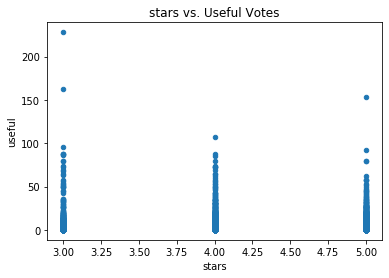

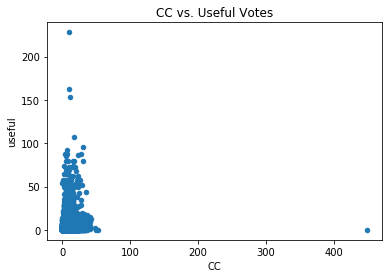

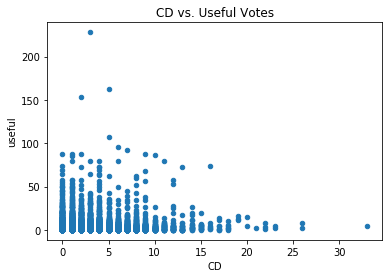

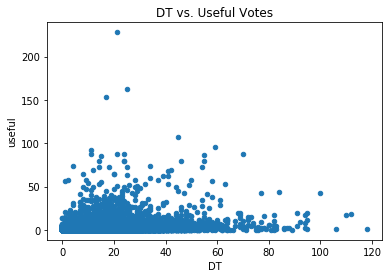

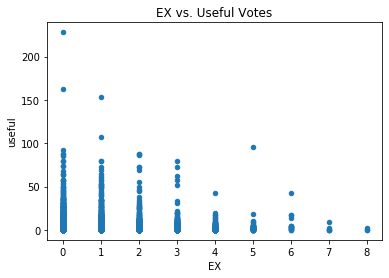

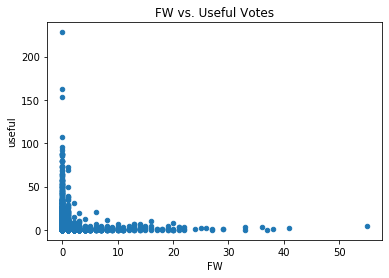

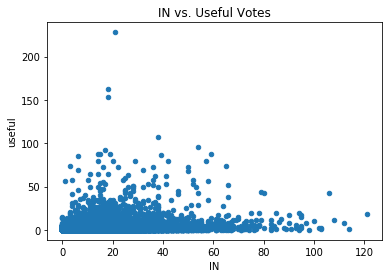

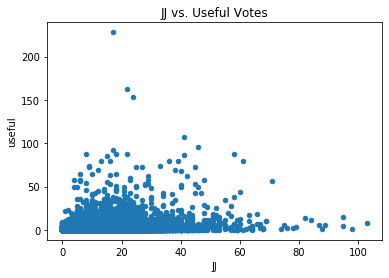

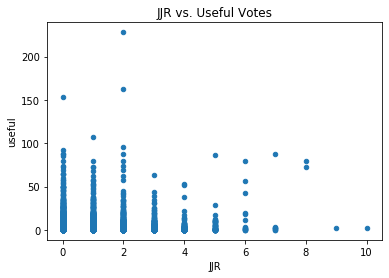

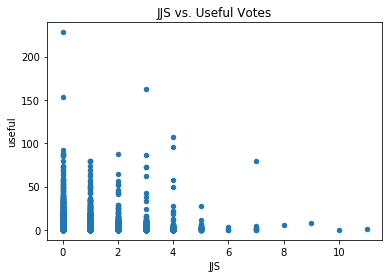

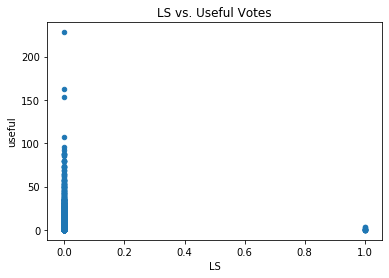

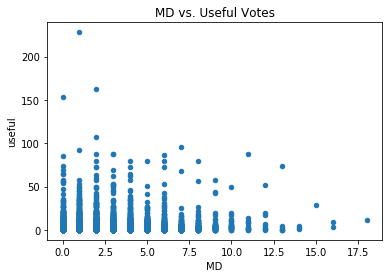

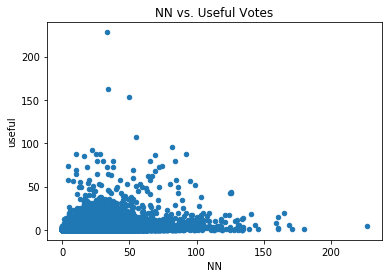

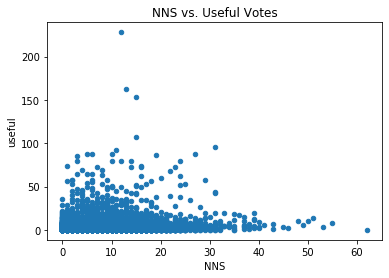

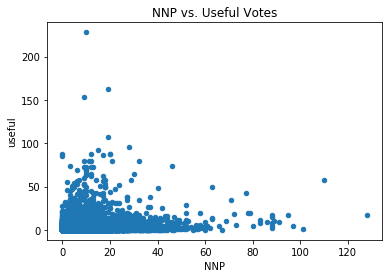

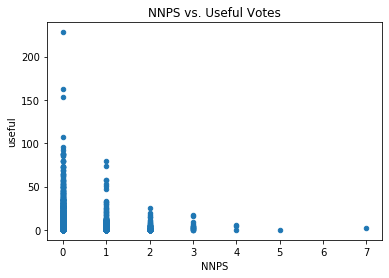

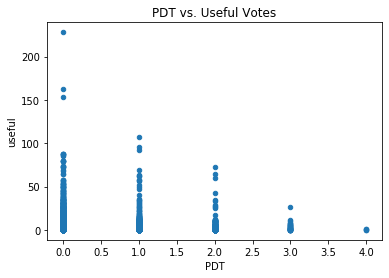

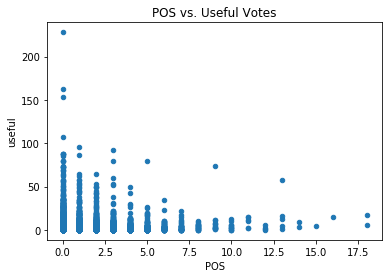

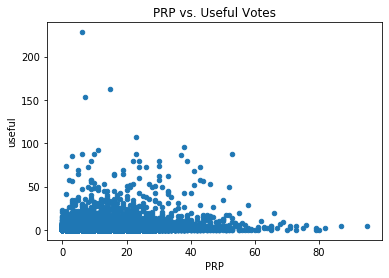

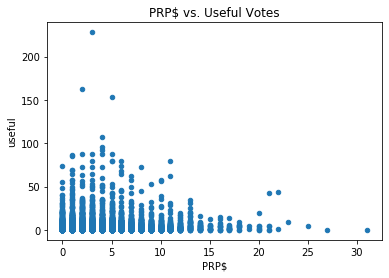

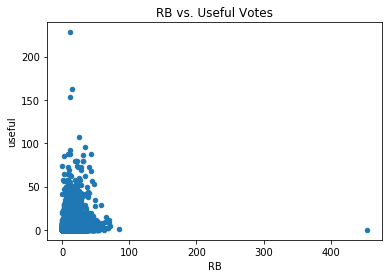

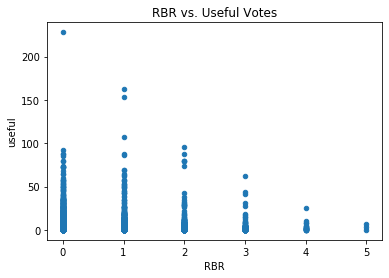

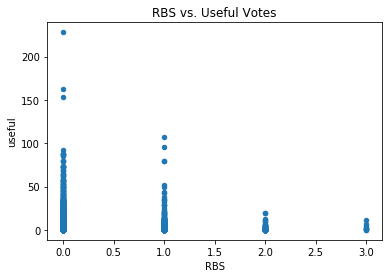

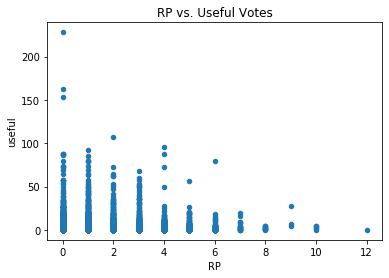

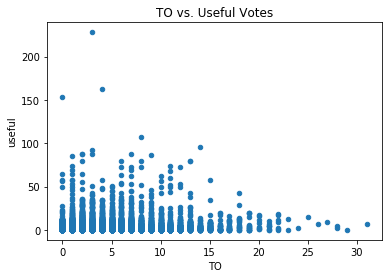

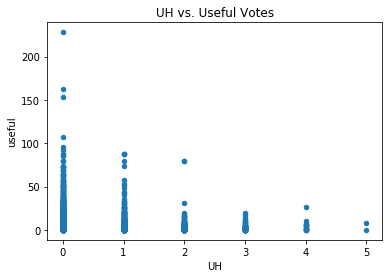

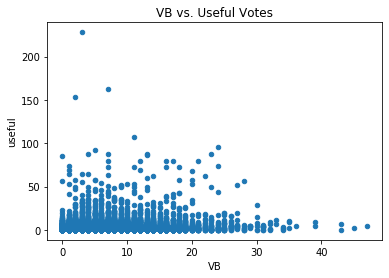

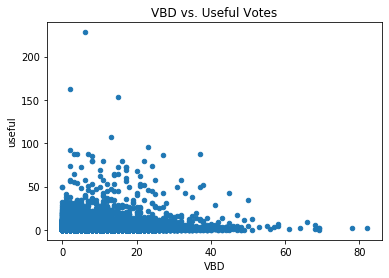

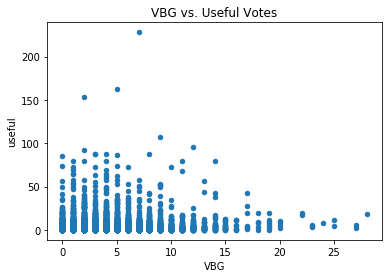

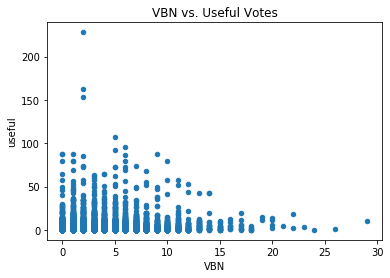

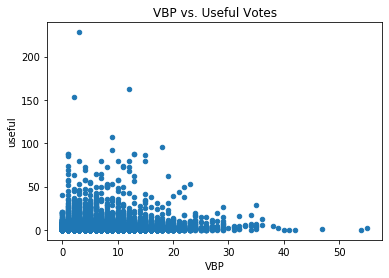

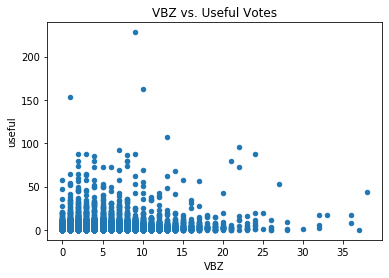

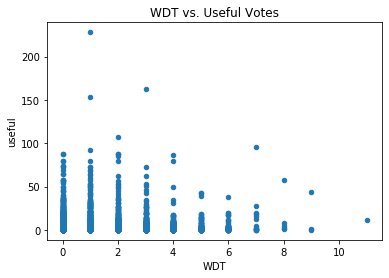

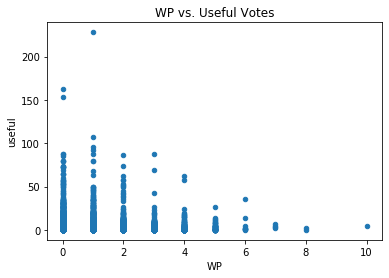

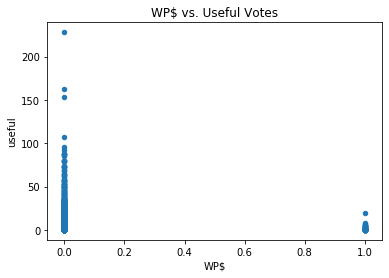

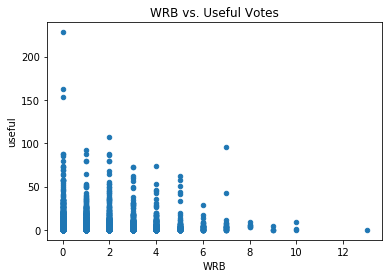

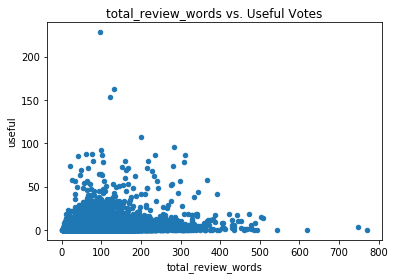

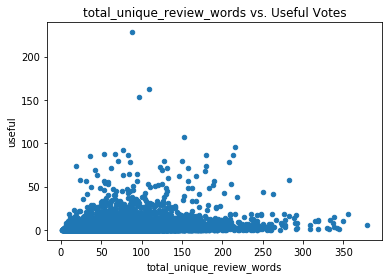

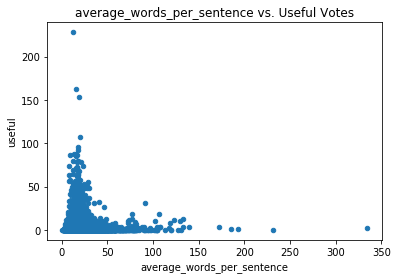

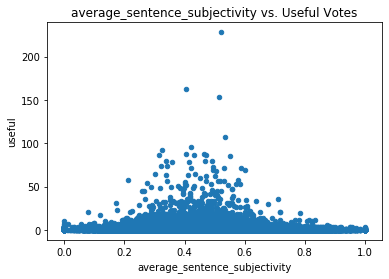

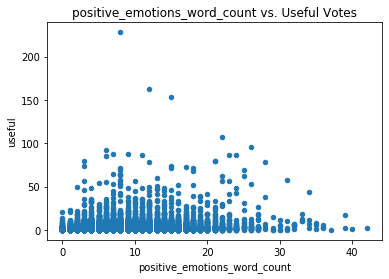

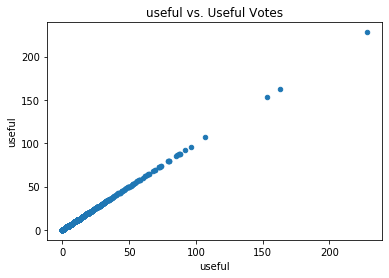

In [79]:
# plot scatter plots for features and usefulness votes
for column in final_df_columns:
    coffee_reviews_final.plot.scatter(x=column, y='useful')
    plt.title("{} vs. Useful Votes".format(column))
    plt.show()

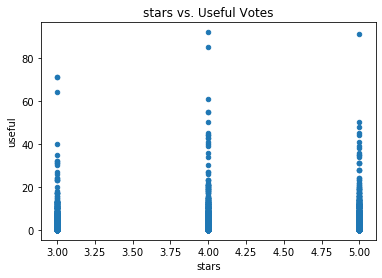

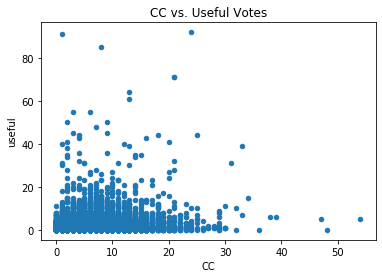

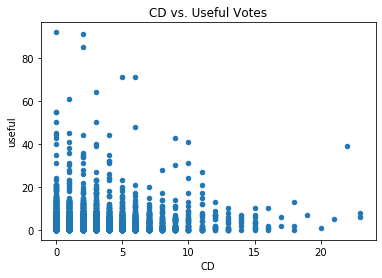

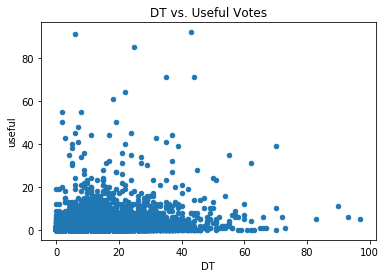

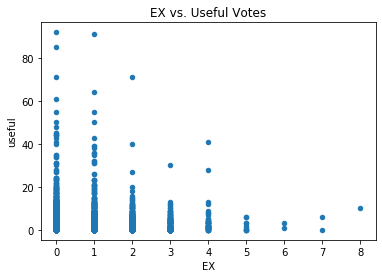

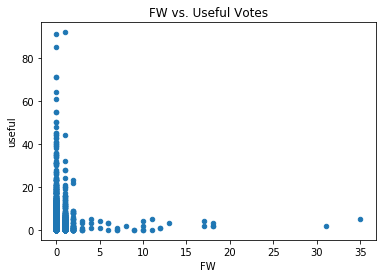

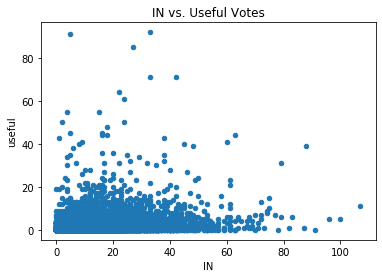

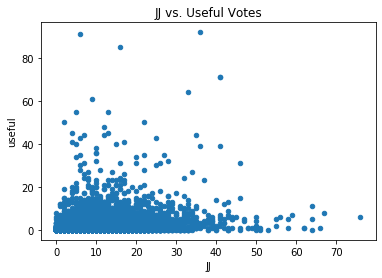

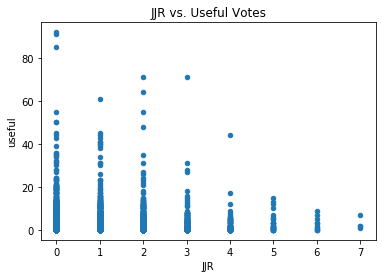

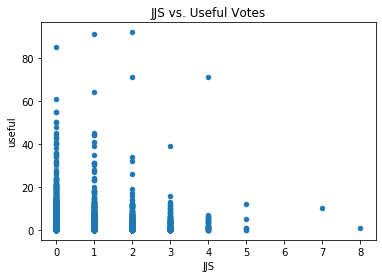

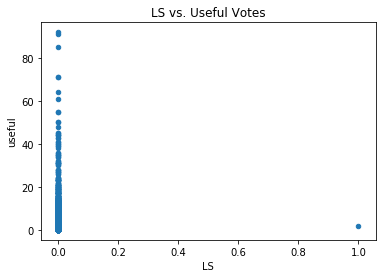

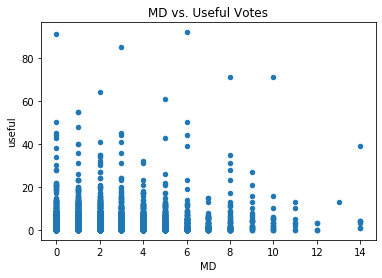

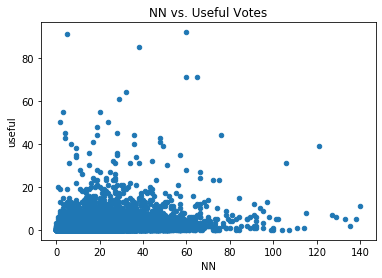

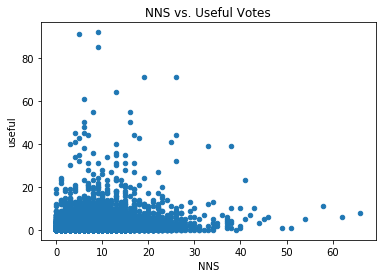

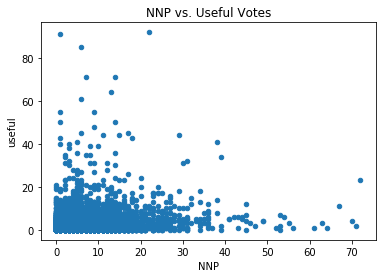

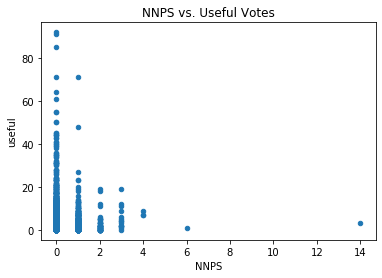

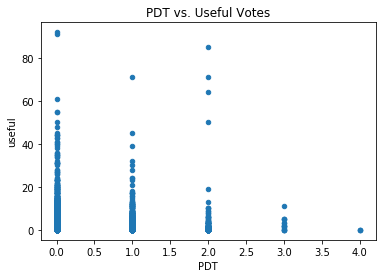

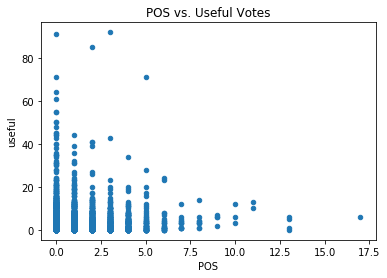

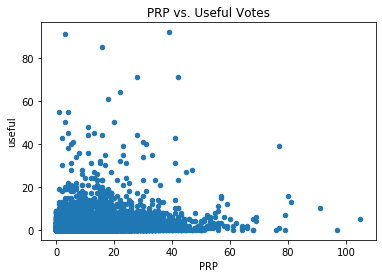

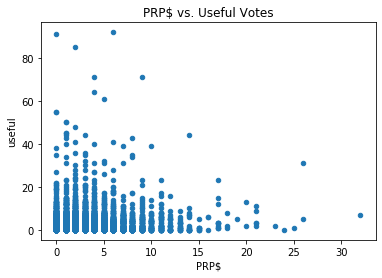

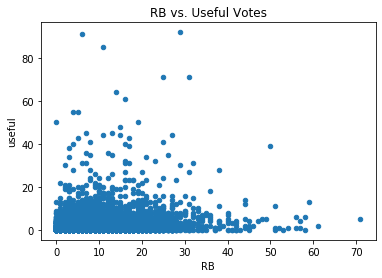

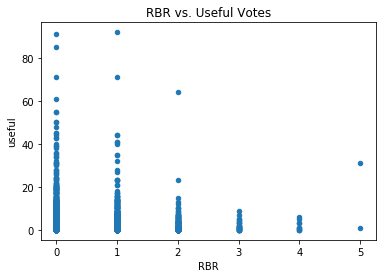

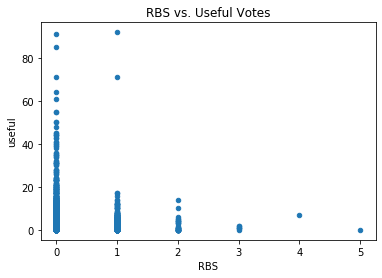

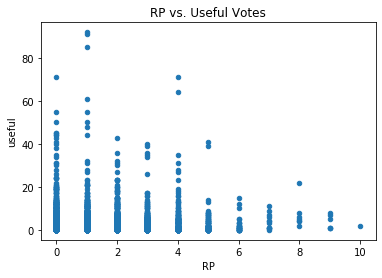

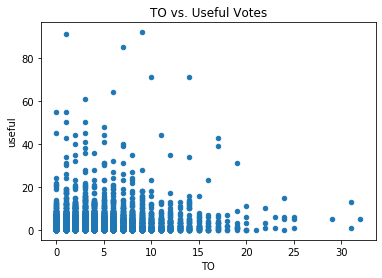

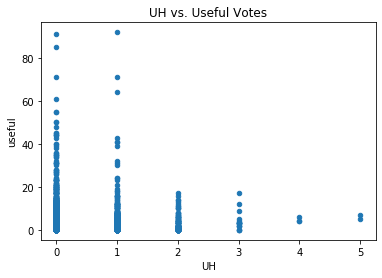

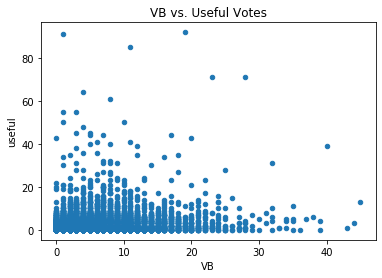

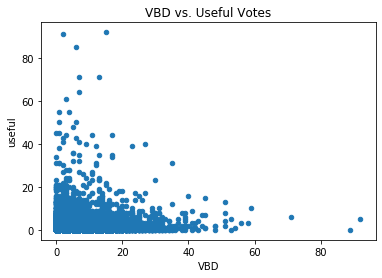

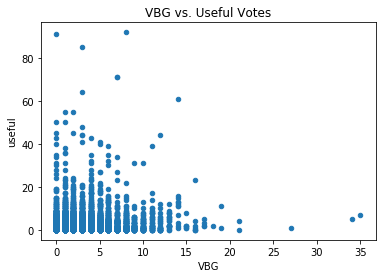

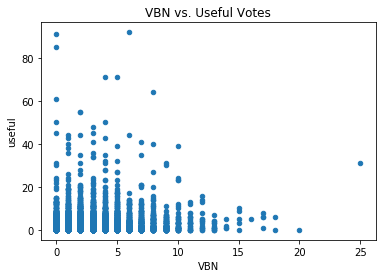

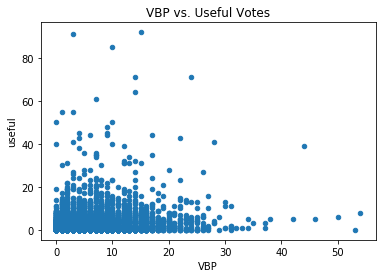

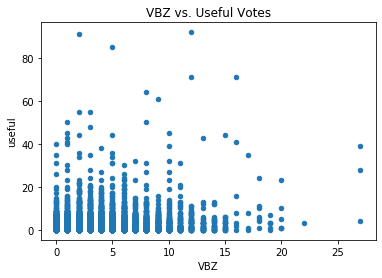

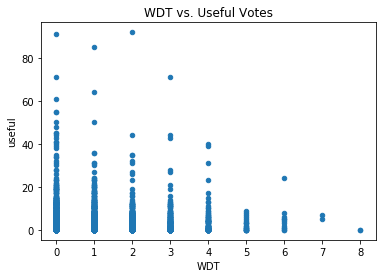

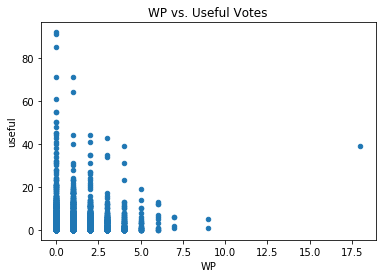

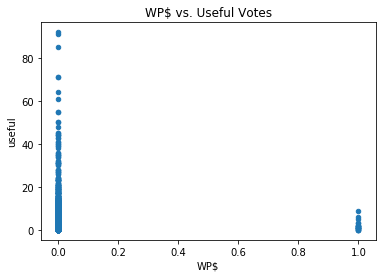

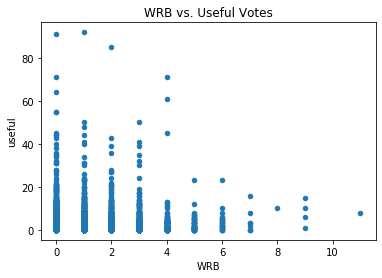

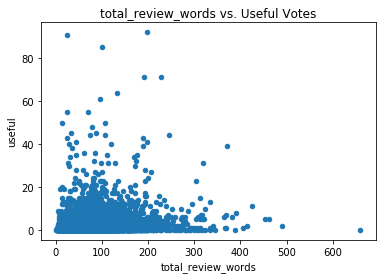

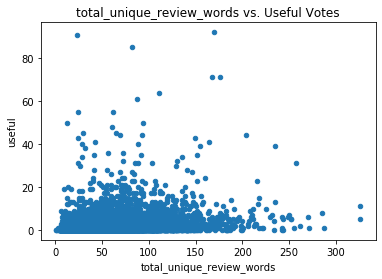

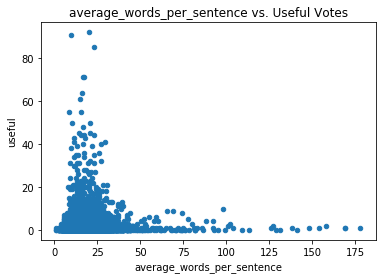

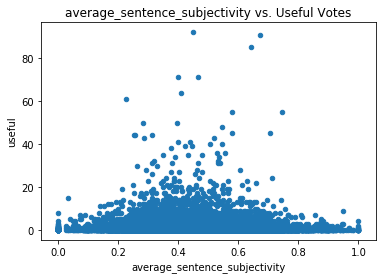

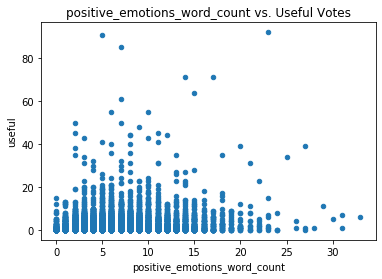

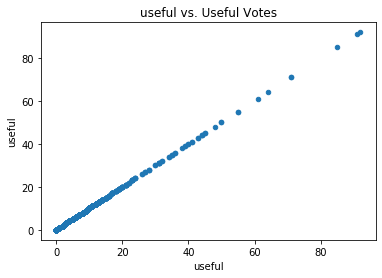

In [80]:
# plot scatter plots for features and usefulness votes
for column in final_df_columns:
    boutique_reviews_final.plot.scatter(x=column, y='useful')
    plt.title("{} vs. Useful Votes".format(column))
    plt.show()

This wasn't terribly useful, however, it is very evident that the most useful reviews are at a "goldilocks" value in terms of subjectivity - not too objective or subjective. Let's add a new column to our datafrmae that just states whether or not a view was useful at all and try some new visualizations. 

In [83]:
for df in final_review_dataframes:
    df['is_useful'] = df['useful'].apply(lambda x: 1 if x > 0 else 0)

In [84]:
# create targets for modeling
coffee_useful = coffee_reviews_final['is_useful']
boutique_useful = boutique_reviews_final['is_useful']

In [85]:
# make sure function worked
coffee_reviews_final.head()

stars  CC  CD  DT  EX  FW  IN  JJ  JJR  JJS  ...  WP  WP$  WRB  \
0    5.0   7   1  18   0   1  18  12    0    1  ...   2    0    0   
1    3.0   5   0   7   1   0   6   6    0    1  ...   0    0    0   
2    5.0   3   1   6   1   0   6   6    0    0  ...   0    0    0   
3    5.0   1   0   4   0   0   1   2    0    0  ...   0    0    0   
4    5.0   6   0  10   0   0  11  16    0    0  ...   0    0    0   

   total_review_words  total_unique_review_words  average_words_per_sentence  \
0                 111                         89                   18.166667   
1                  34                         26                   12.666667   
2                  37                         35                   19.750000   
3                  15                         12                    7.750000   
4                  58                         49                   12.700000   

   average_sentence_subjectivity  positive_emotions_word_count  useful  \
0                       0.607407                            10      11   
1                       0.400000                             4       0   
2                       0.437469                             6       0   
3                       0.375000                             2       0   
4                       0.673519                            13       1   

   is_useful  
0          1  
1          0  
2          0  
3          0  
4          1  

[5 rows x 43 columns]

Now let's try some new visualizations. We will only include values within three standard deviations of the mean in order to make the chart easier to interpret. 

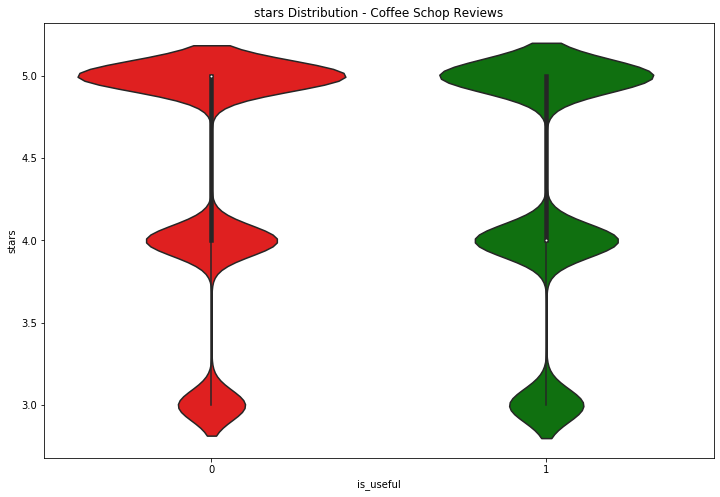

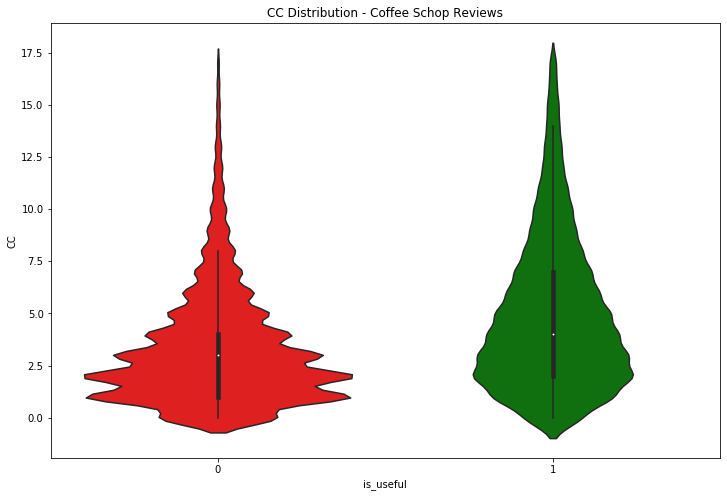

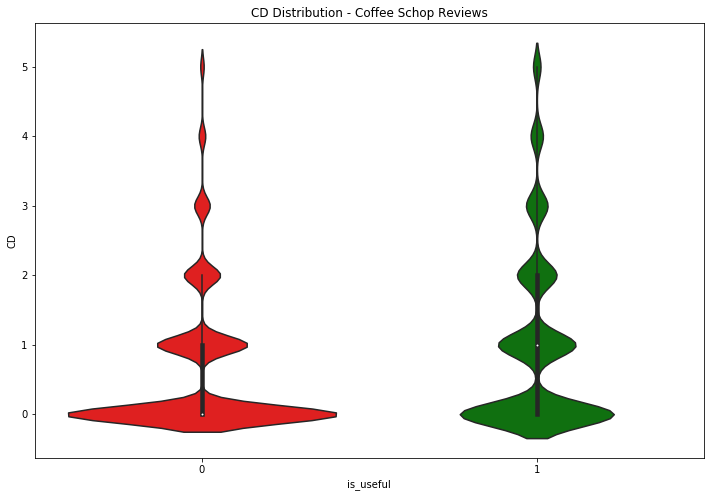

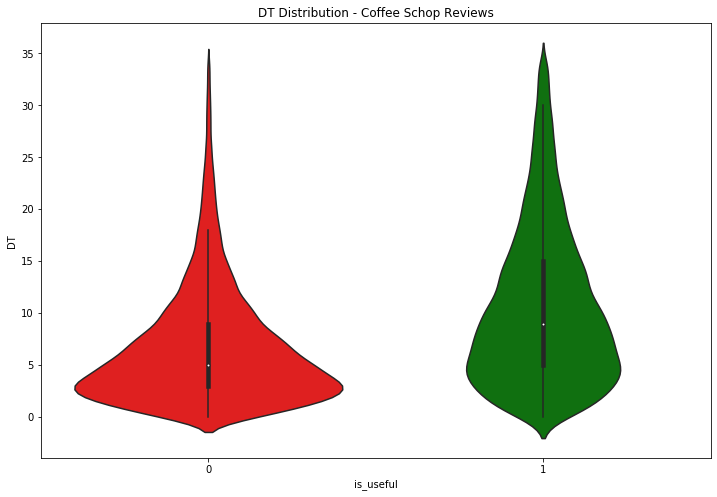

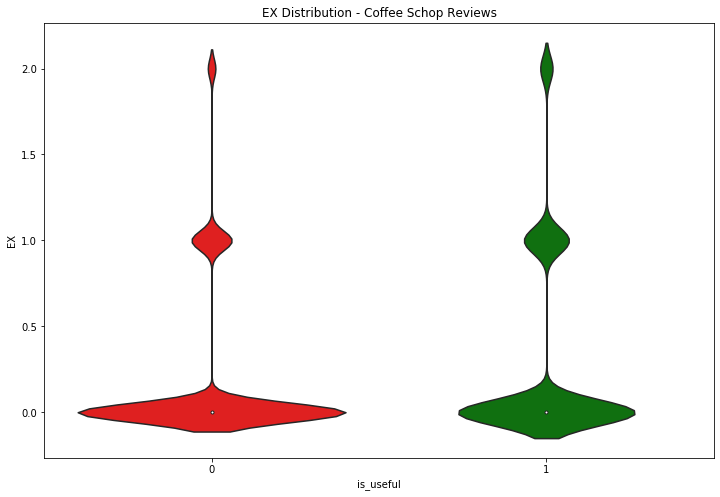

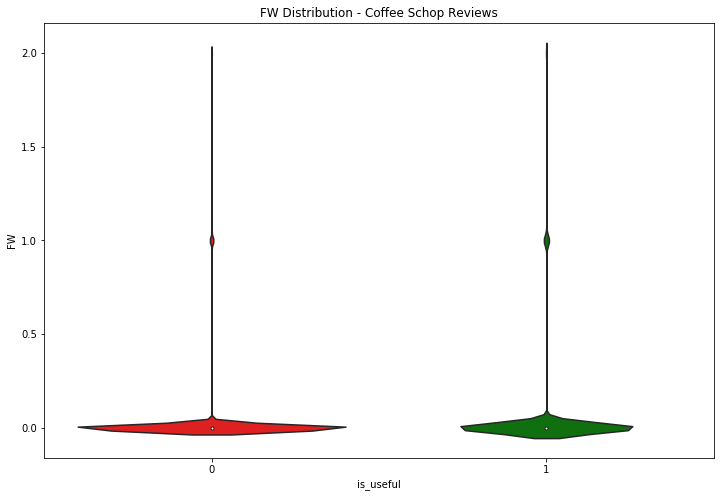

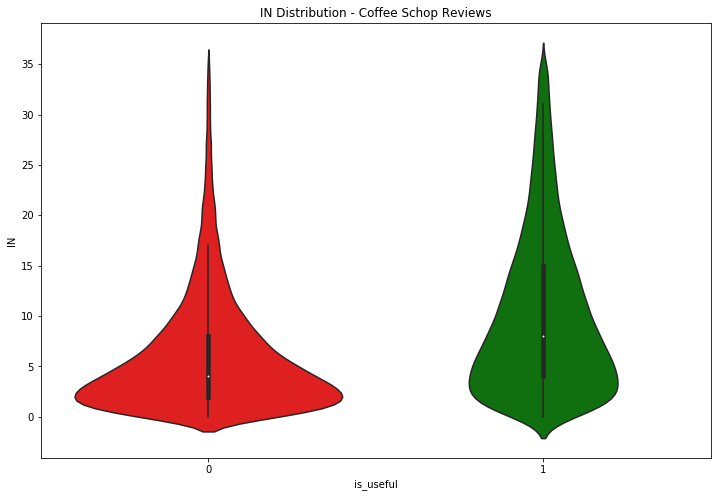

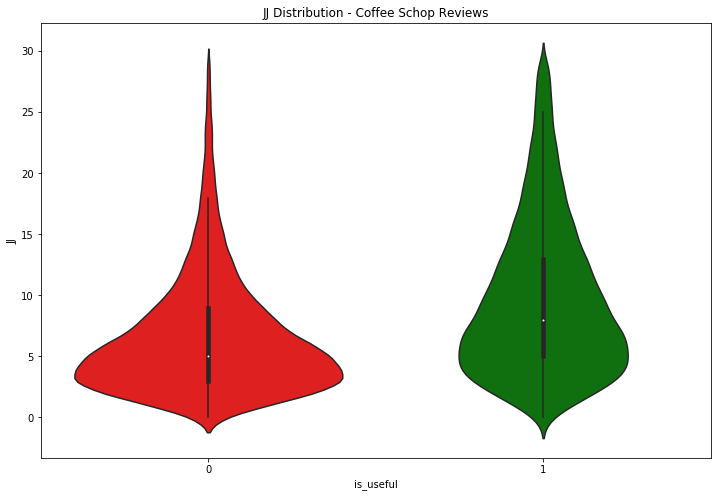

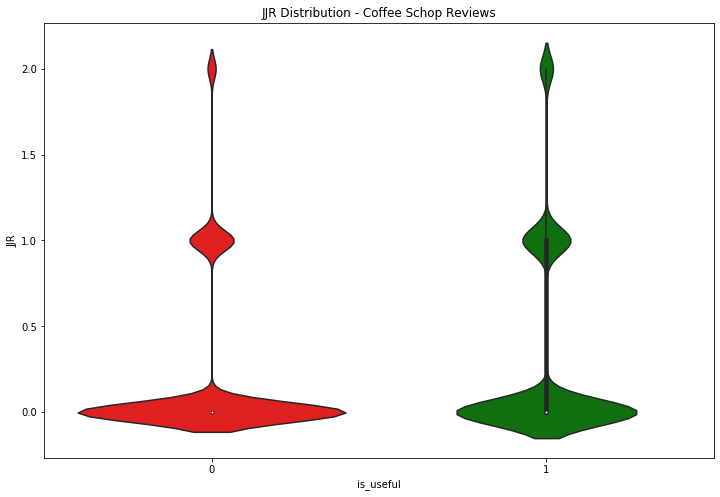

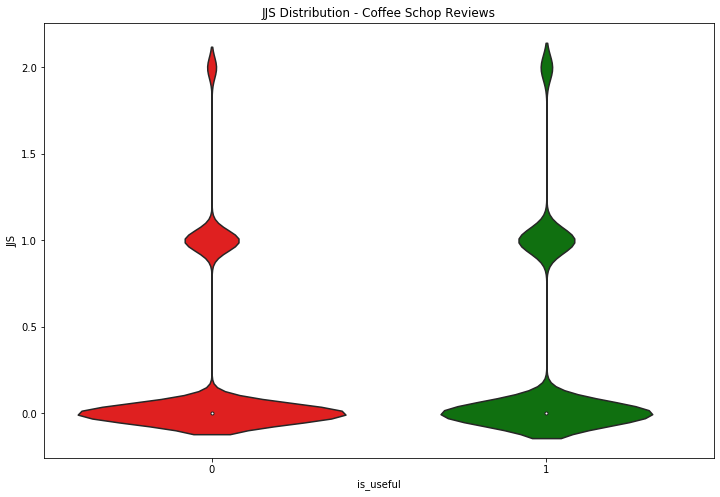

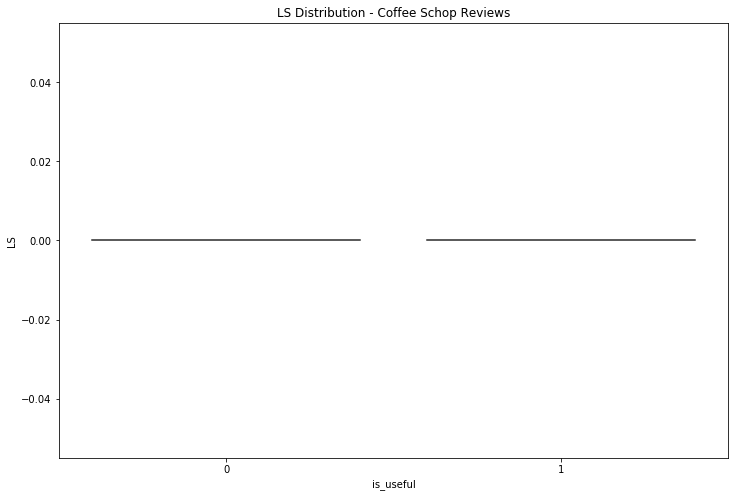

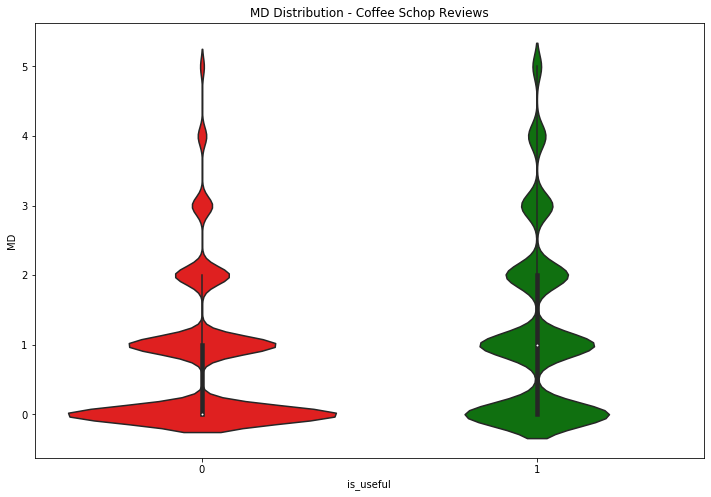

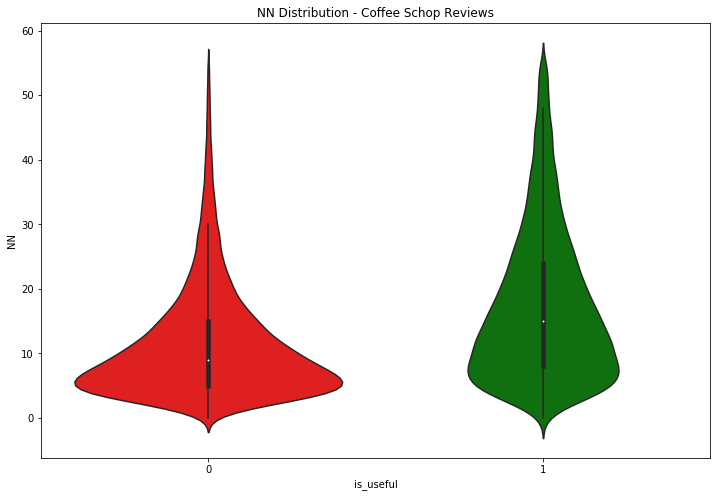

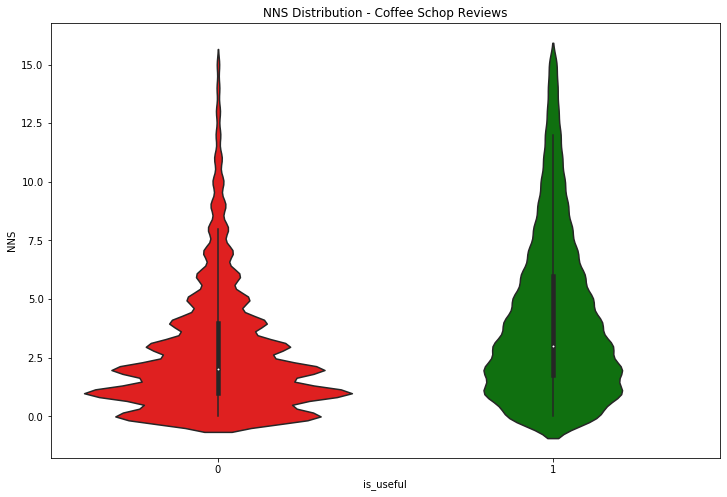

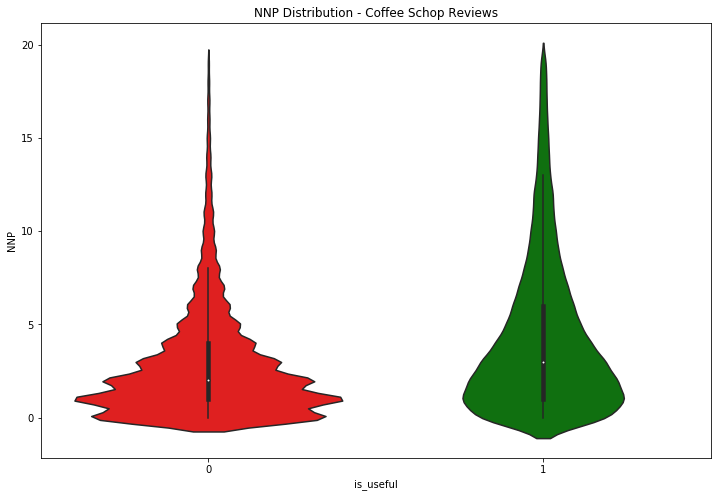

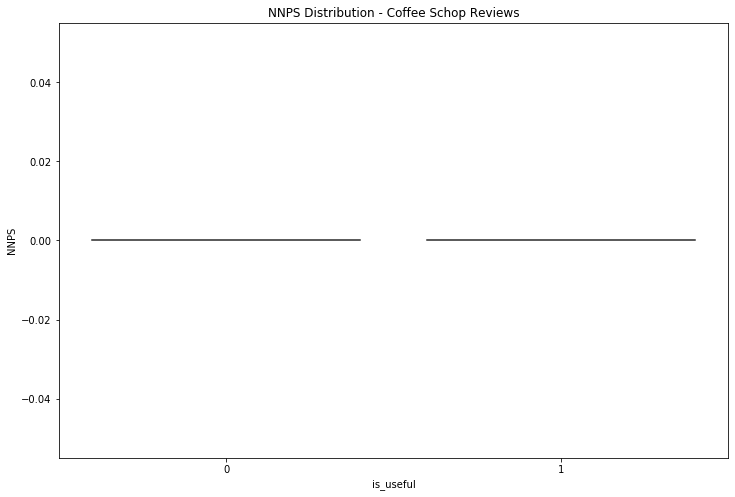

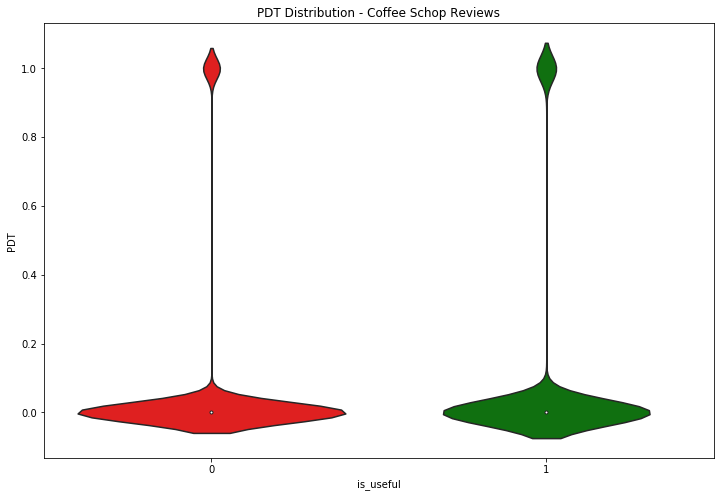

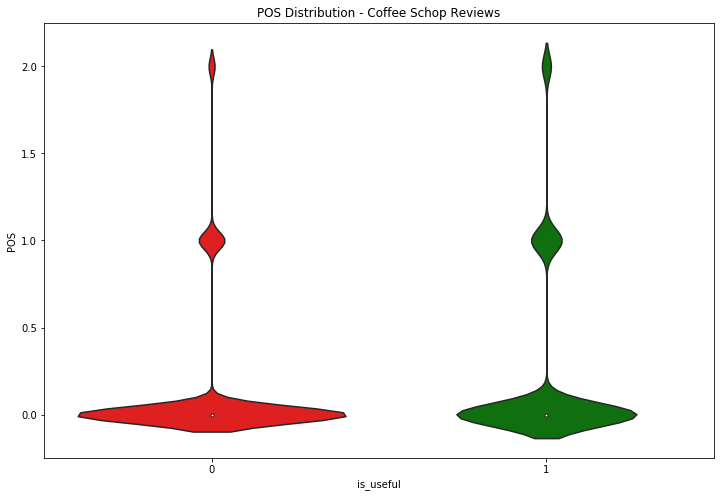

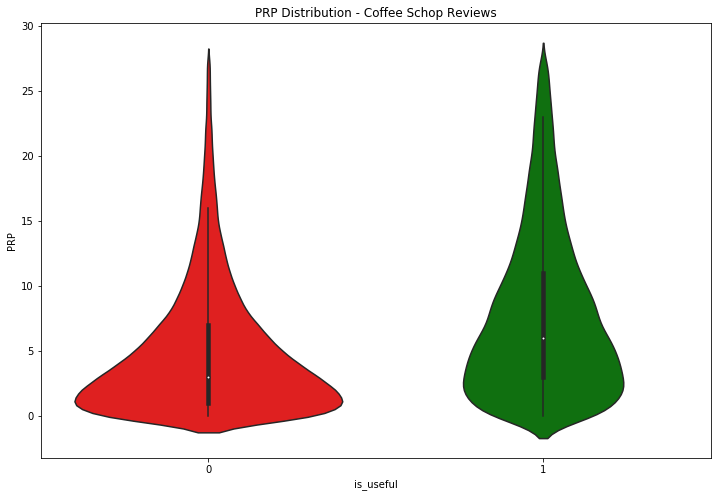

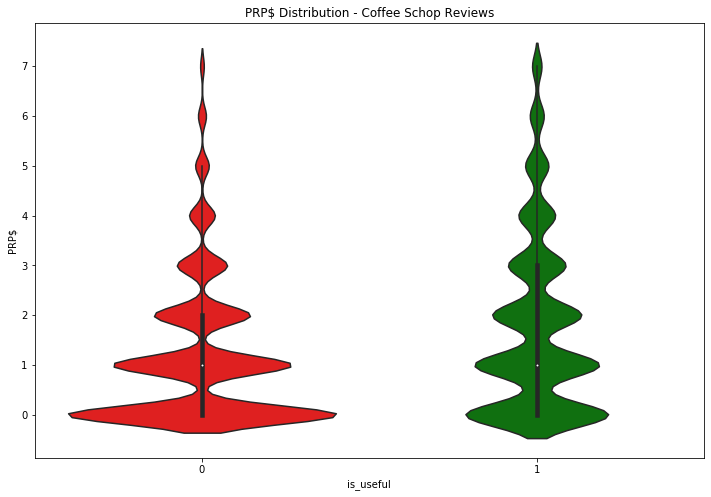

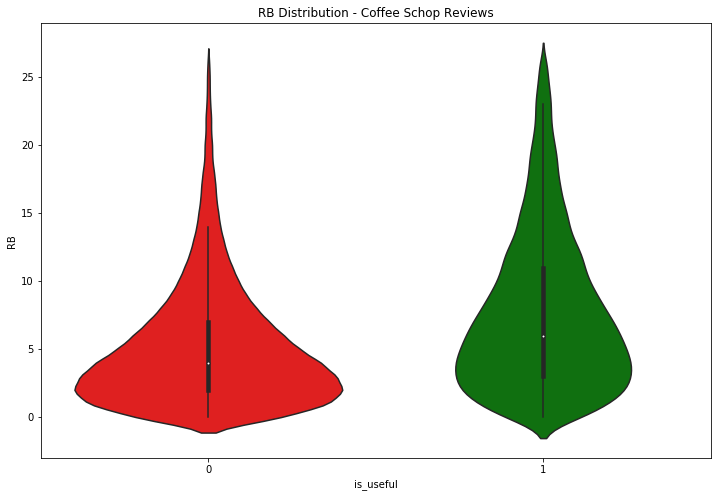

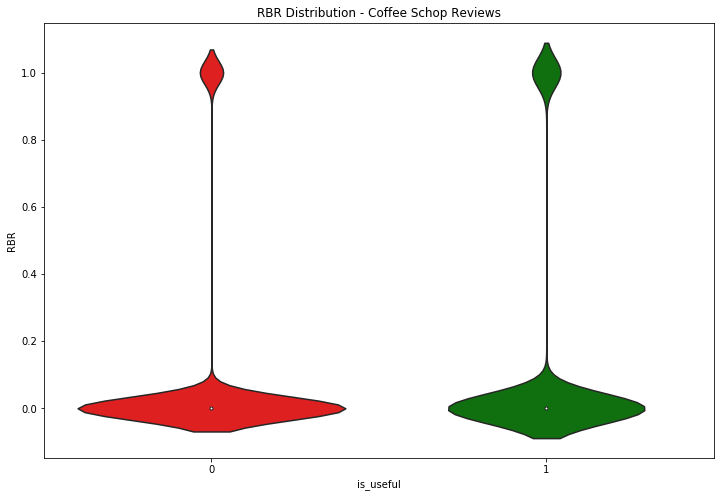

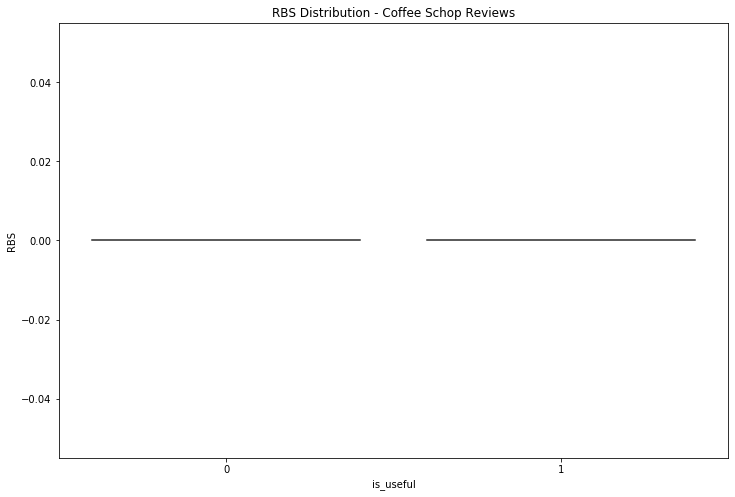

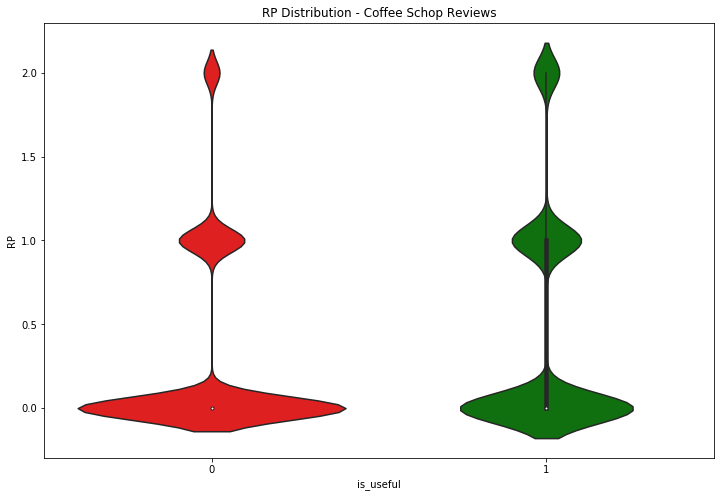

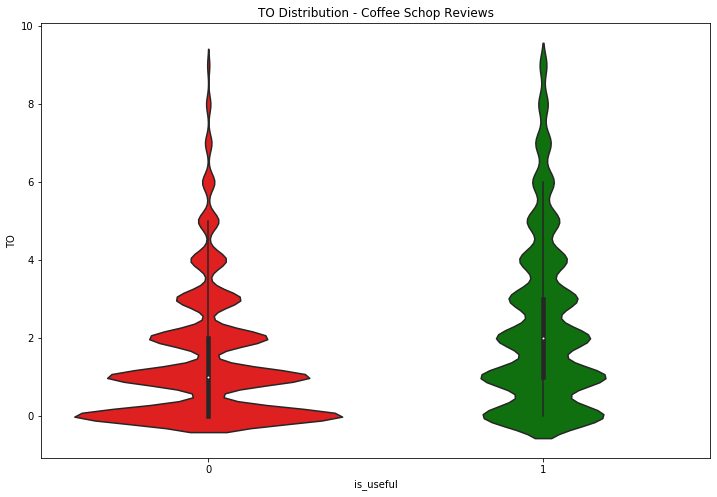

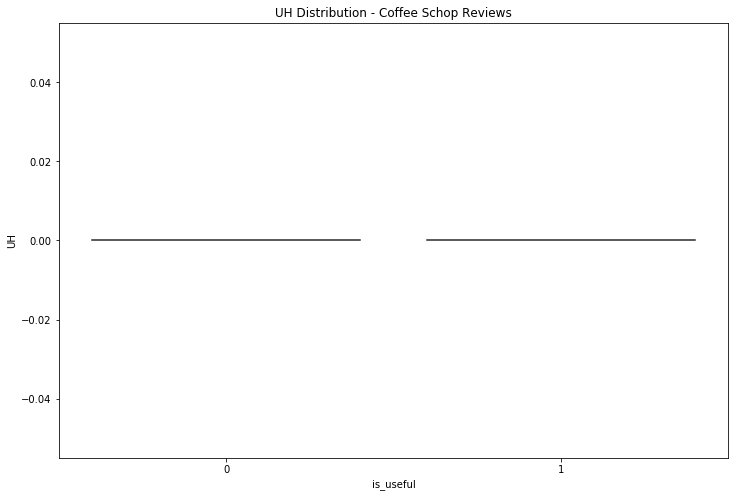

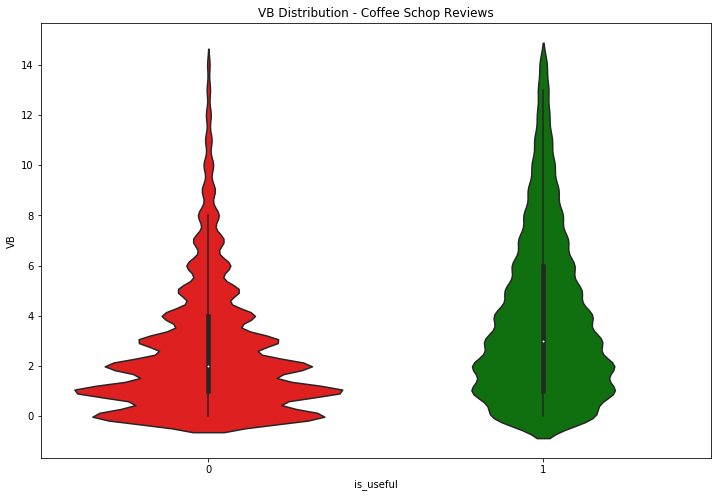

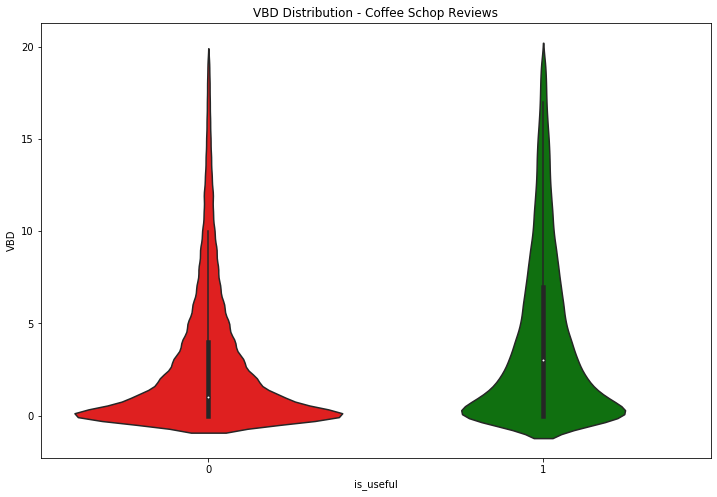

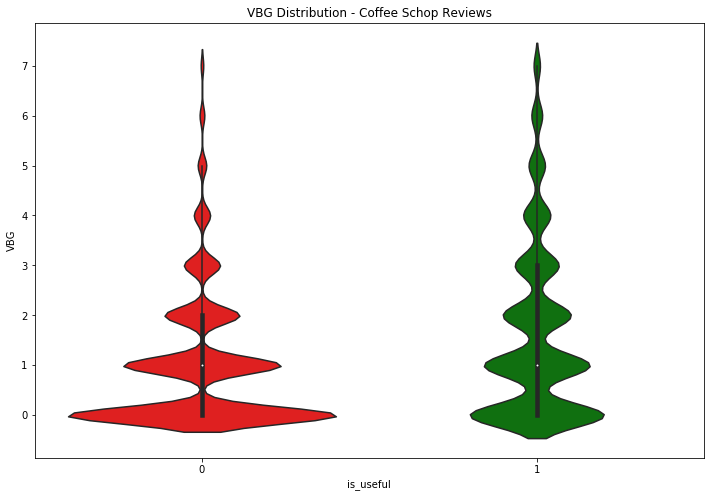

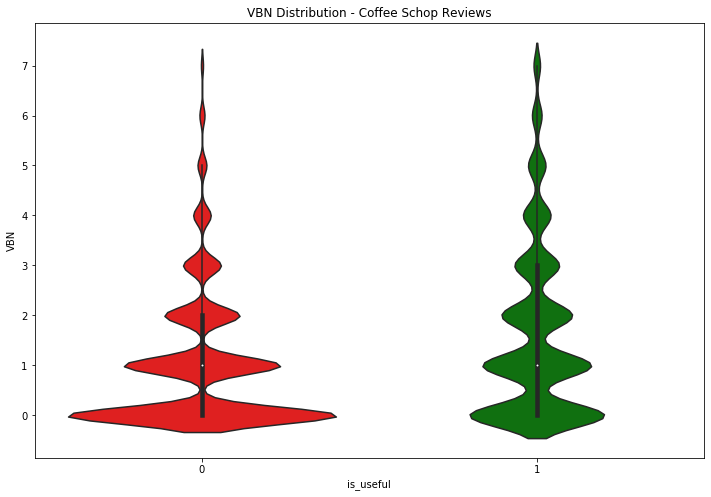

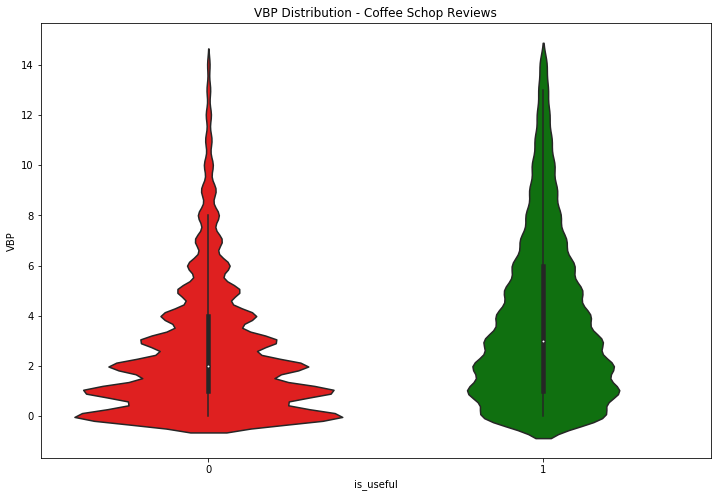

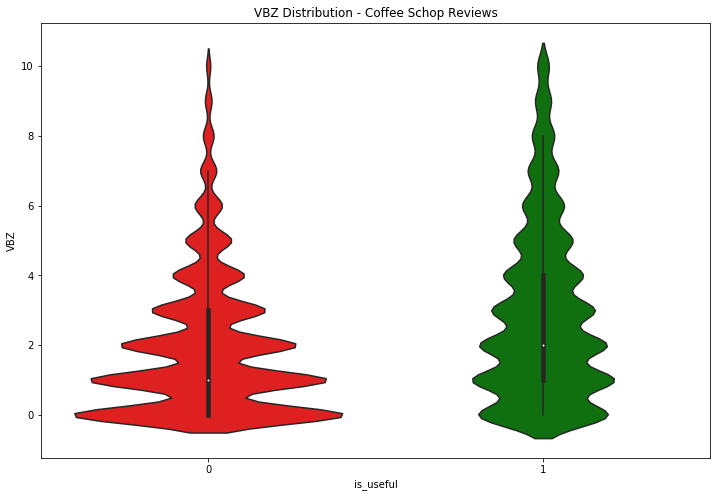

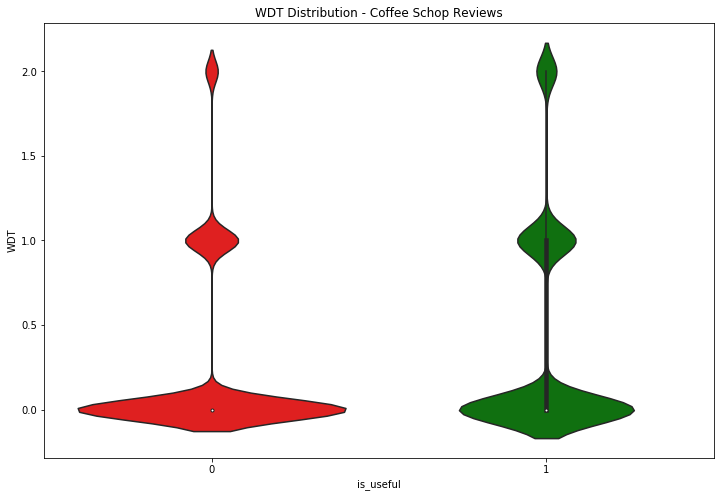

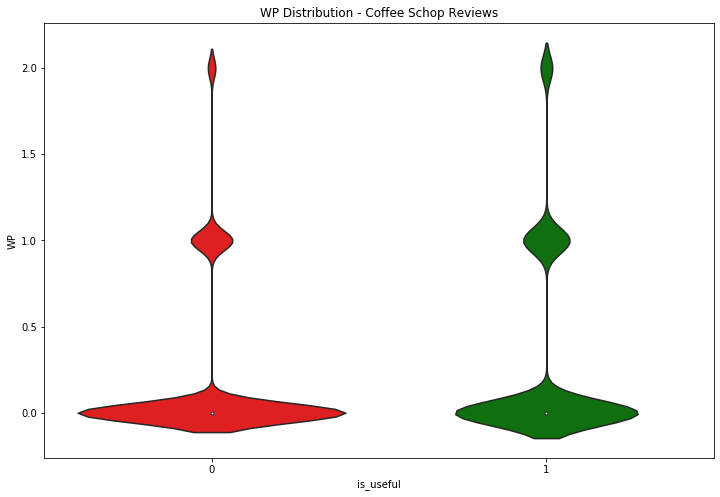

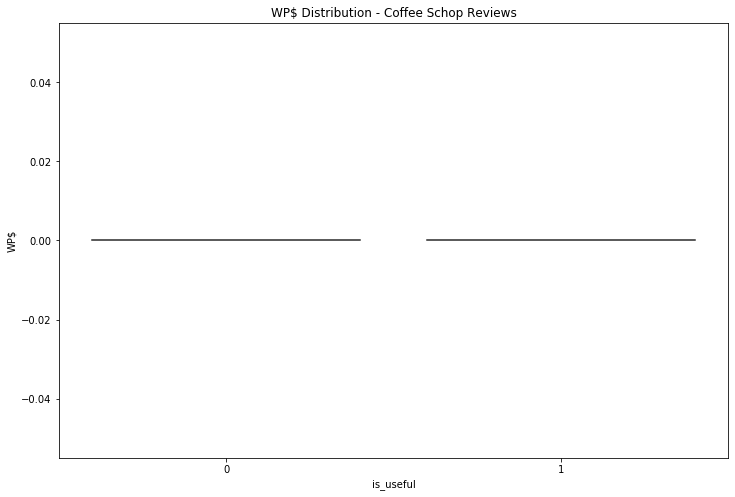

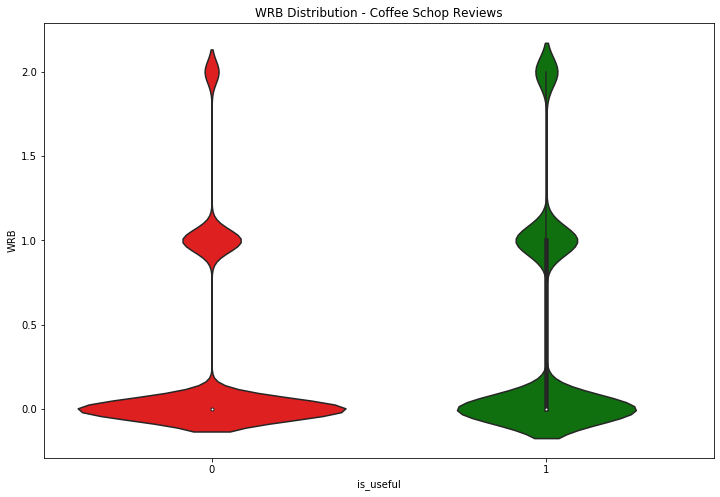

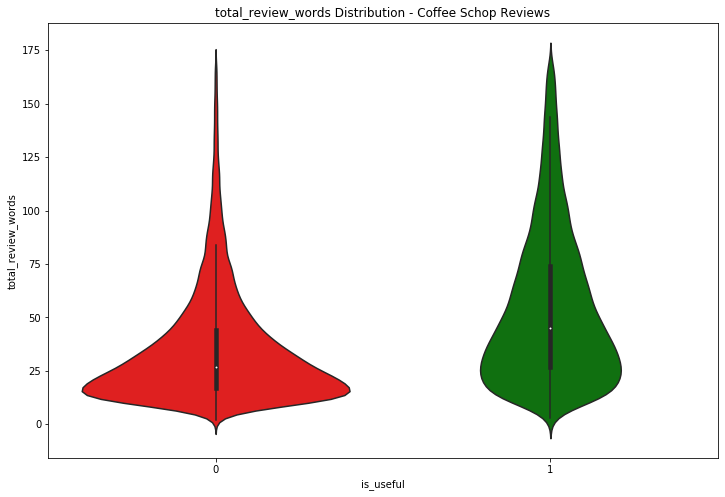

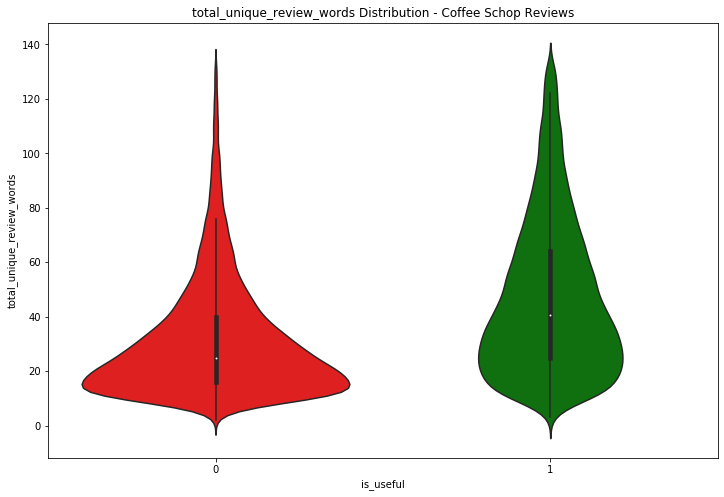

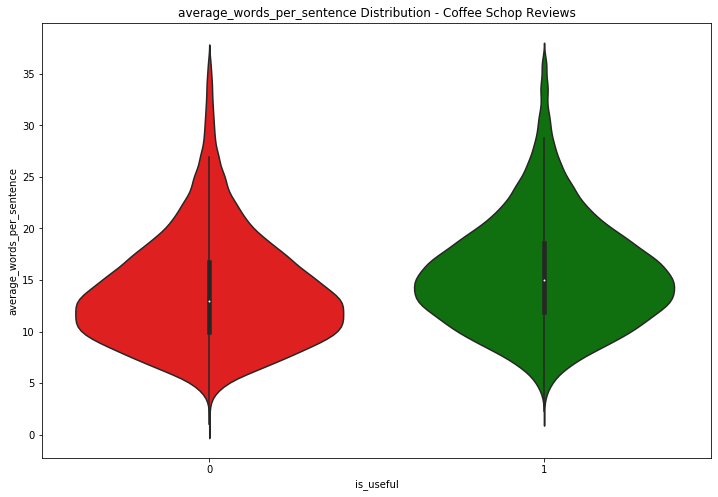

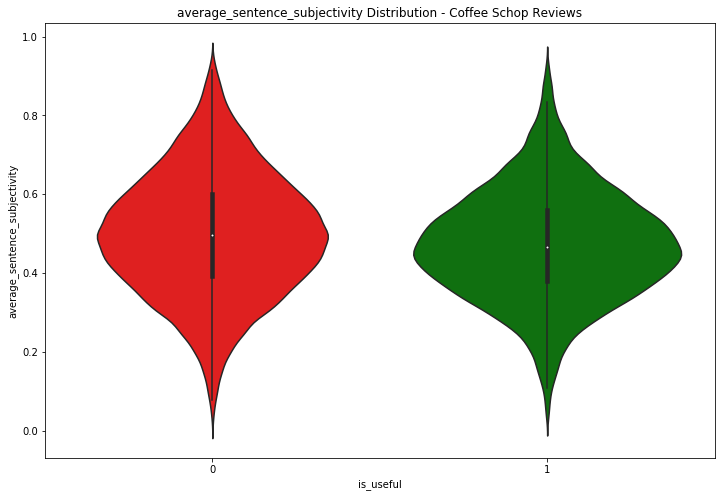

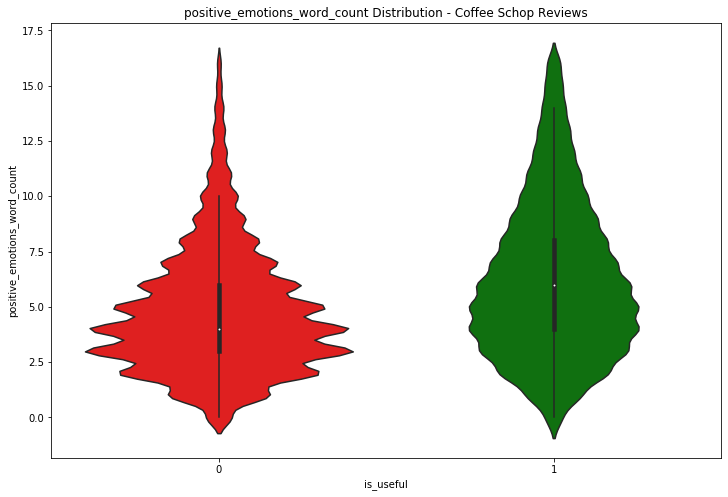

In [86]:
# now let's plot each continuous feature as a distribution
for feature in final_features:
    # create temp dataframe with just values less than three std from the mean
    temp_df = coffee_reviews_final[[feature, 'is_useful']]
    temp_df = temp_df[np.abs(temp_df[feature]-temp_df[feature].mean()) <= (3*temp_df[feature].std())]
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    p1=sns.violinplot(x="is_useful", y=feature, data=temp_df, palette = ['r', 'g'])
    plt.title("{} Distribution - Coffee Schop Reviews".format(feature))

Text(0.5, 0, 'Is Useful')

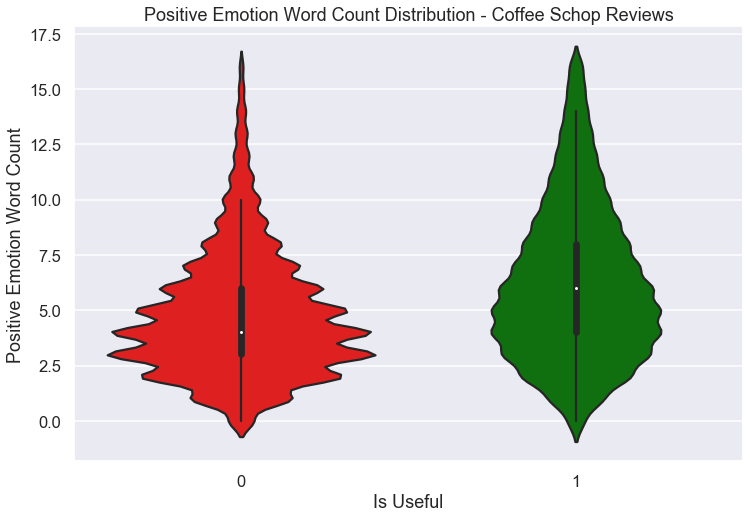

In [113]:
# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create temp dataframe with just values less than three std from the mean
temp_df = coffee_reviews_final[['positive_emotions_word_count', 'is_useful']]
temp_df = temp_df[np.abs(temp_df['positive_emotions_word_count']-temp_df['positive_emotions_word_count'].mean()) <= (3*temp_df['positive_emotions_word_count'].std())]
ax, figure = plt.subplots(1,1,figsize=(12,8))
p1=sns.violinplot(x="is_useful", y='positive_emotions_word_count', data=temp_df, palette = ['r', 'g'])
plt.title("Positive Emotion Word Count Distribution - Coffee Schop Reviews".format(feature))
plt.ylabel("Positive Emotion Word Count")
plt.xlabel("Is Useful")

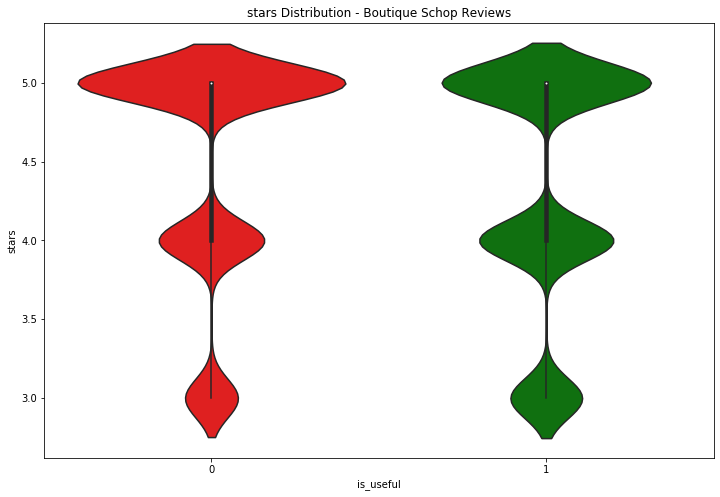

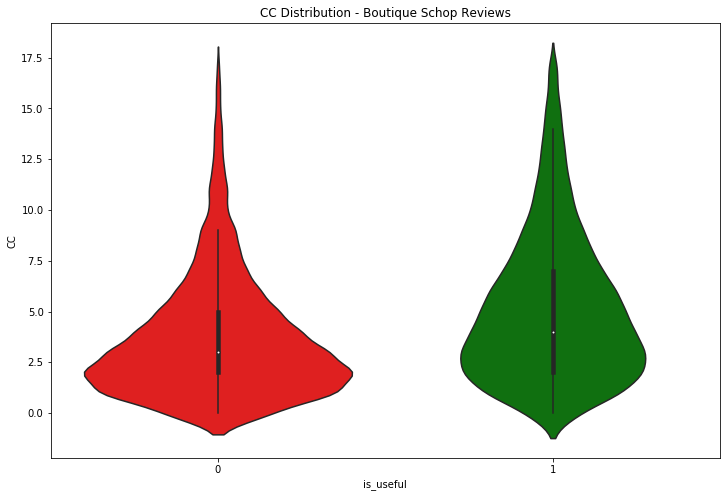

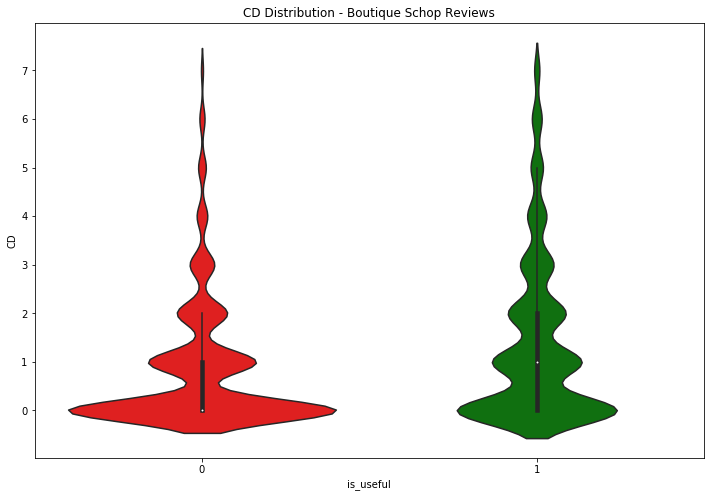

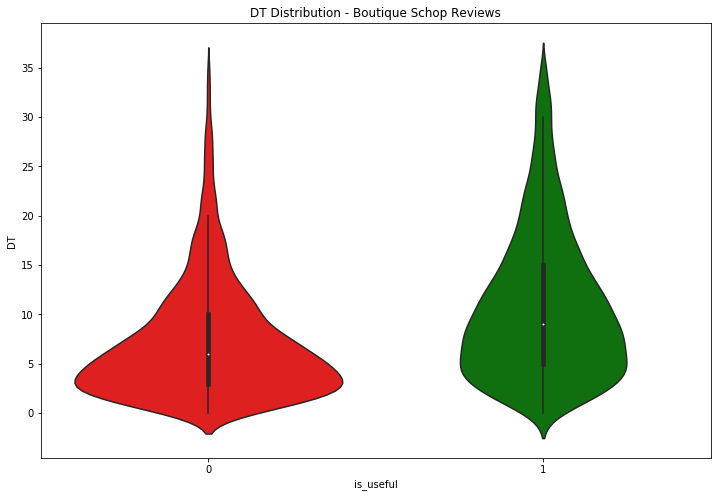

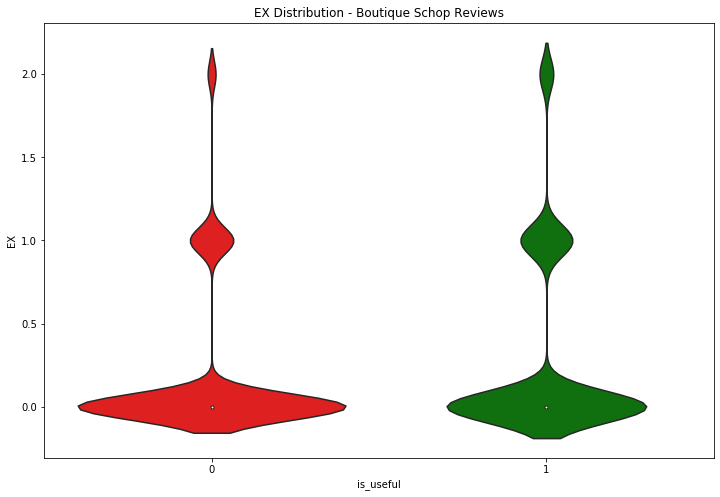

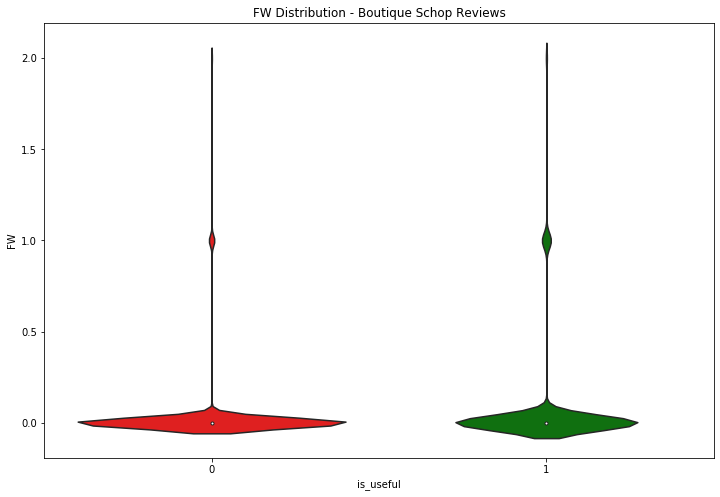

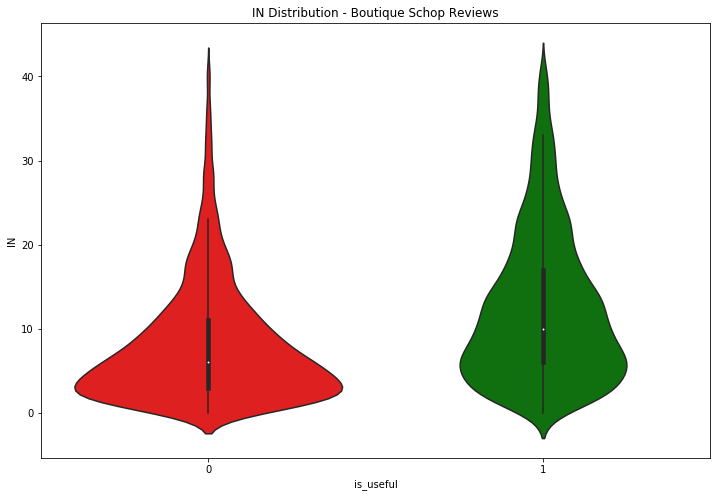

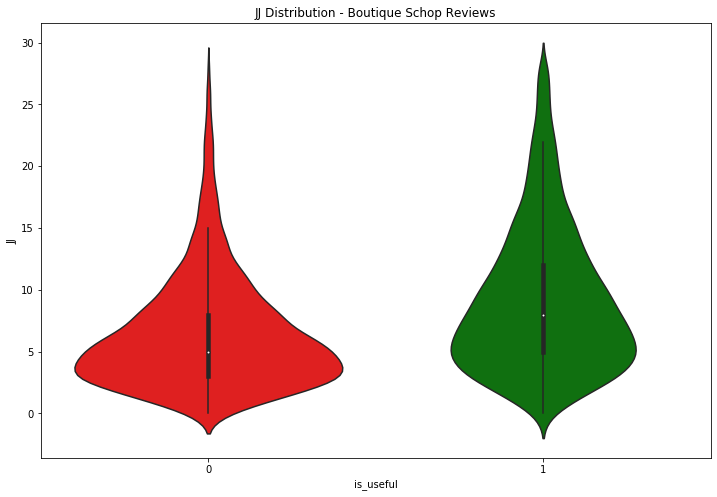

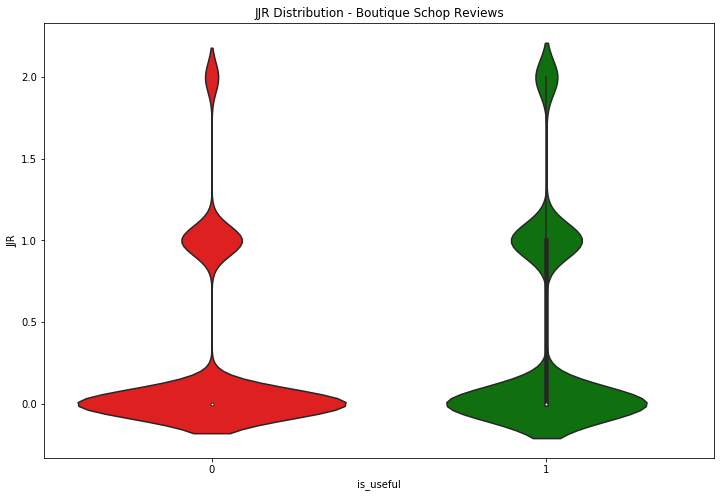

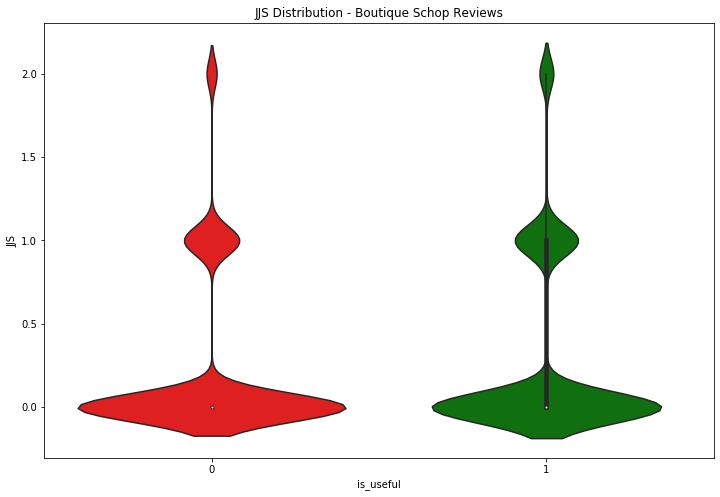

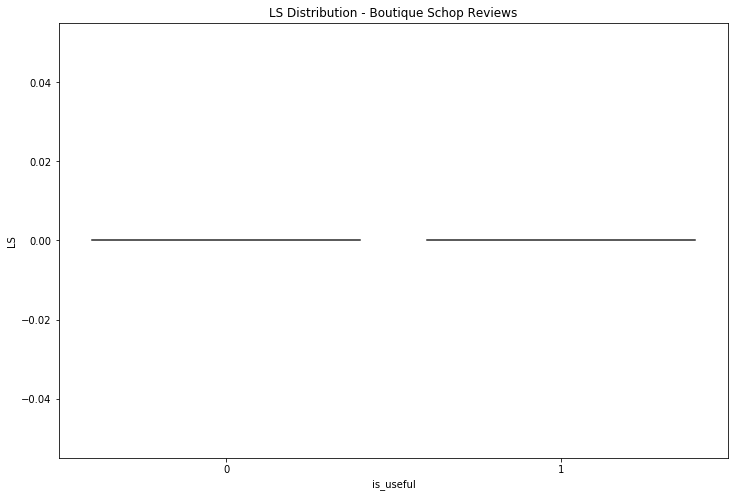

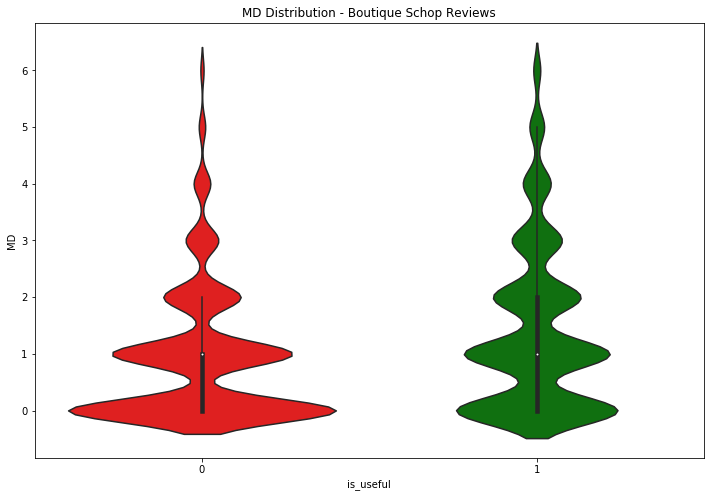

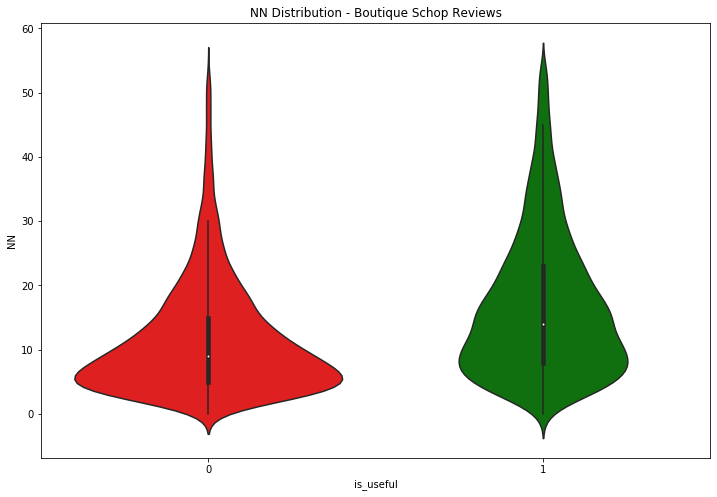

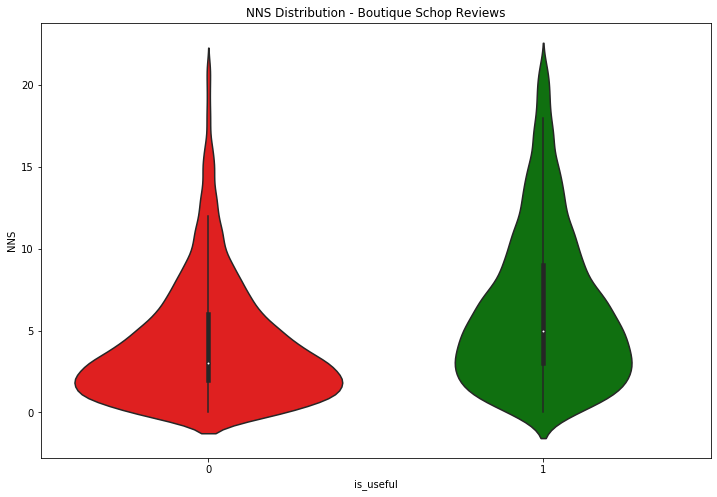

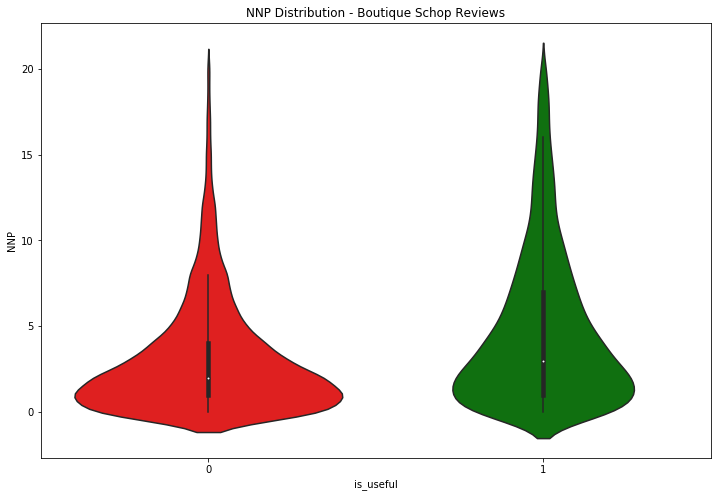

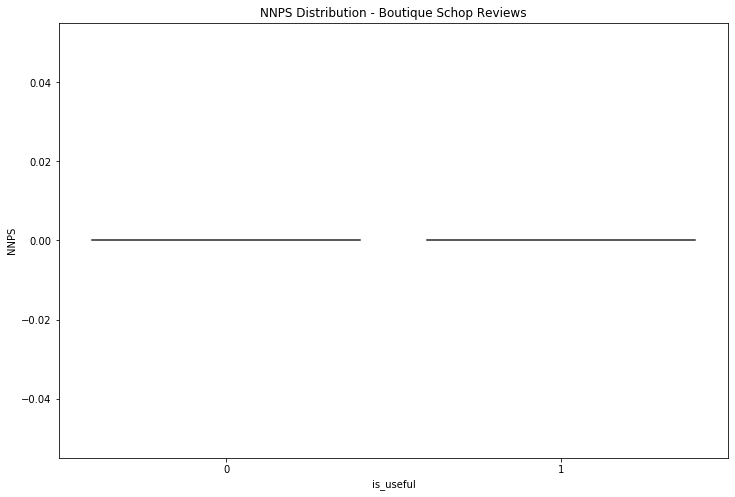

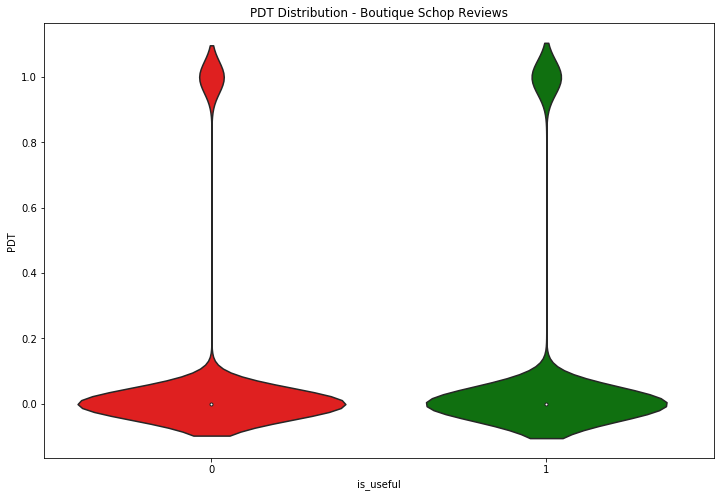

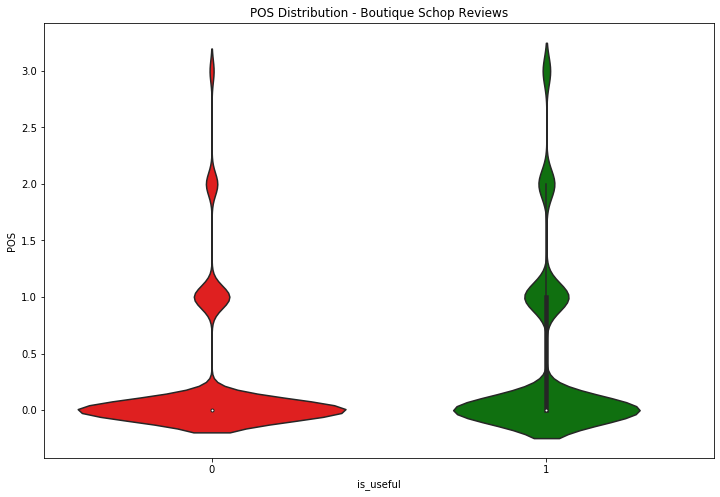

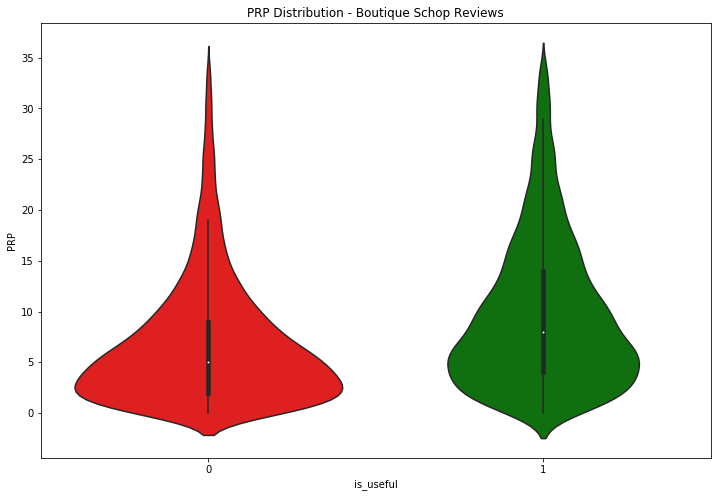

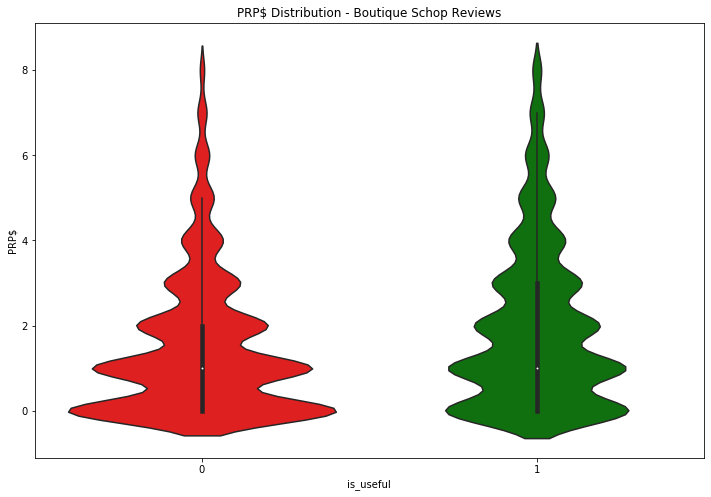

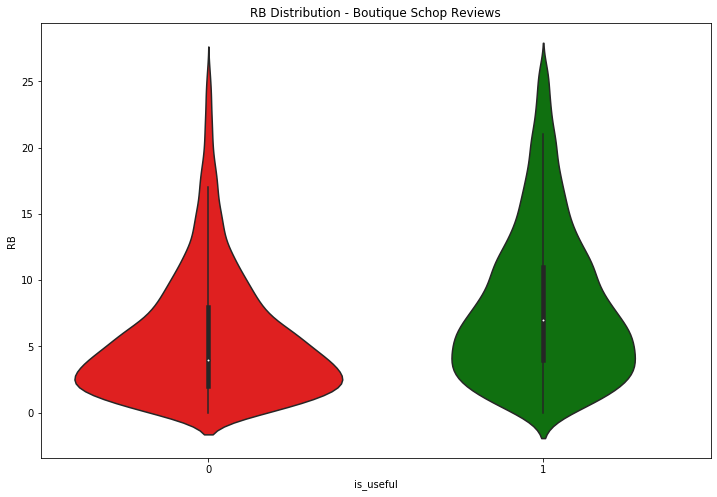

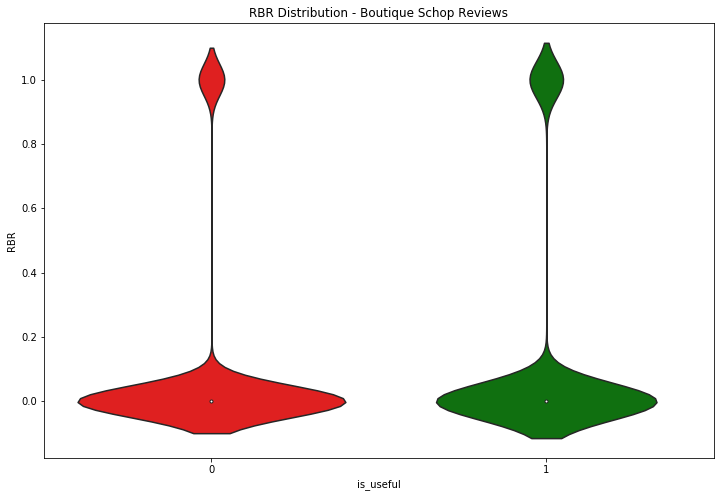

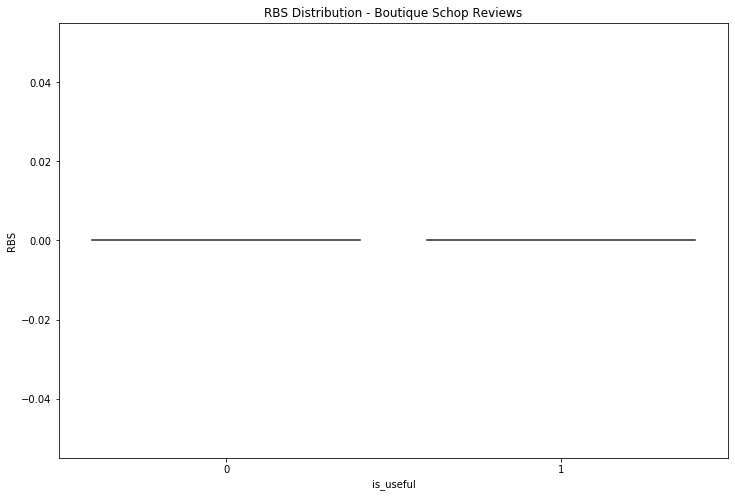

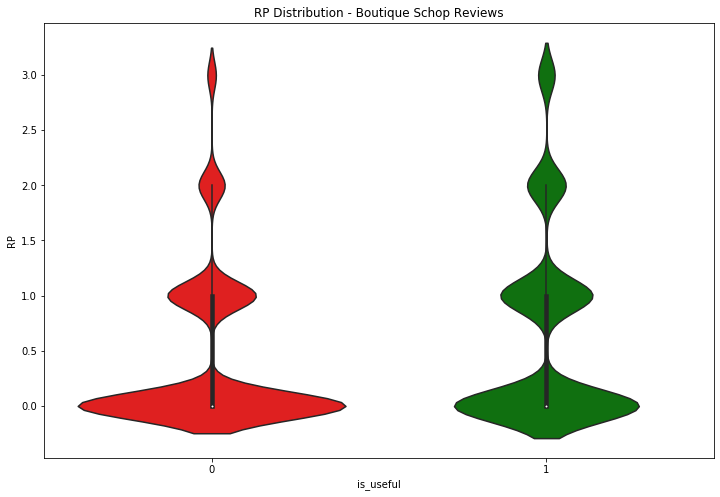

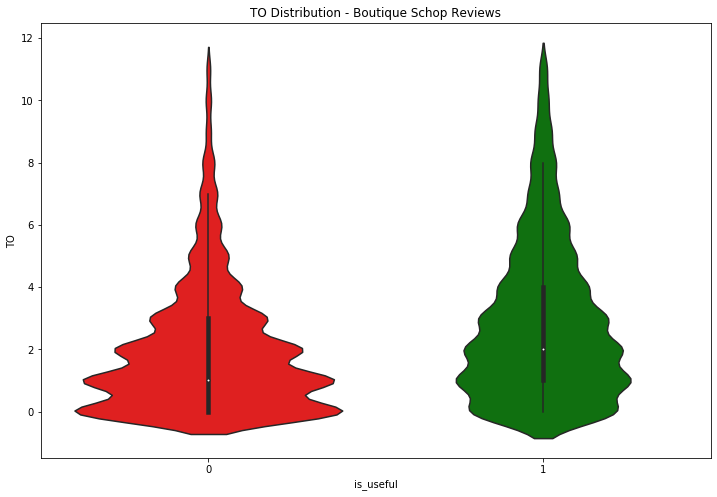

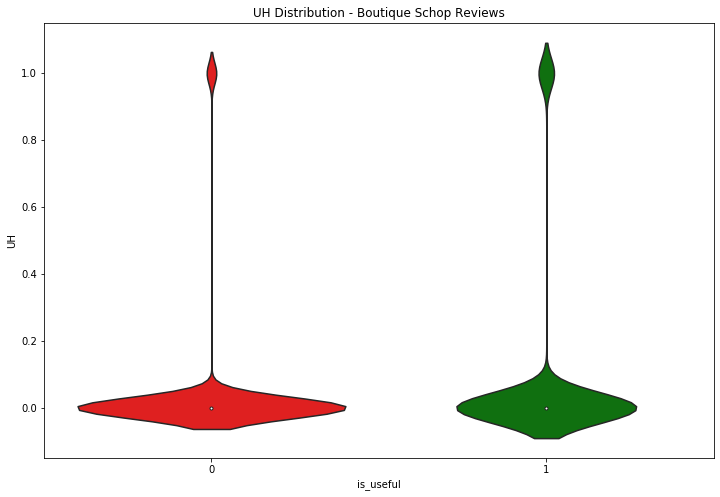

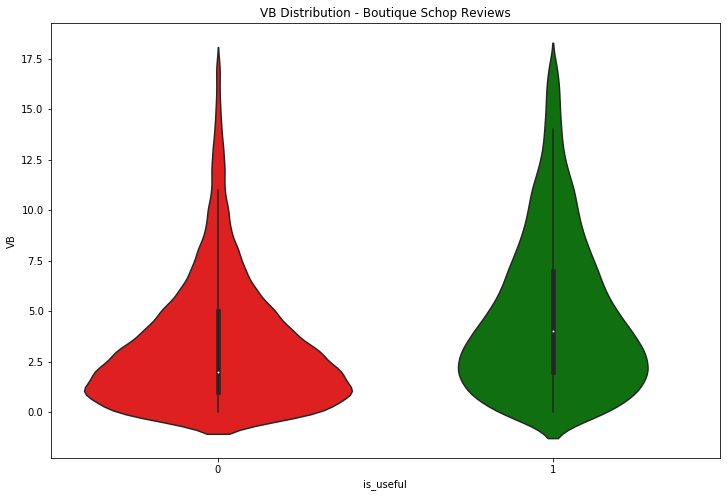

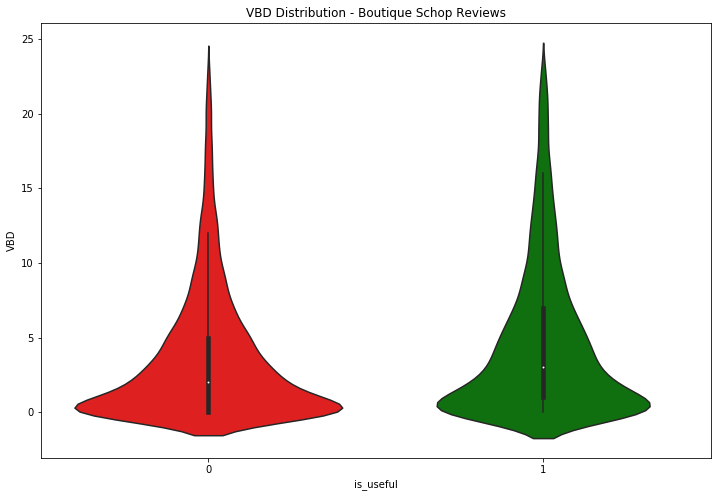

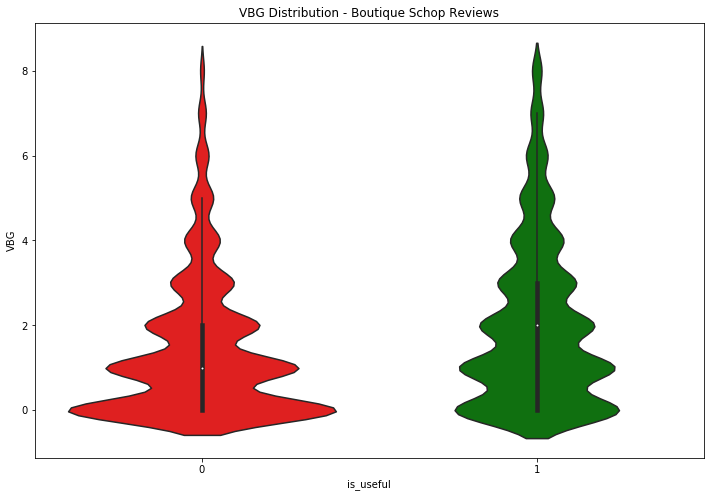

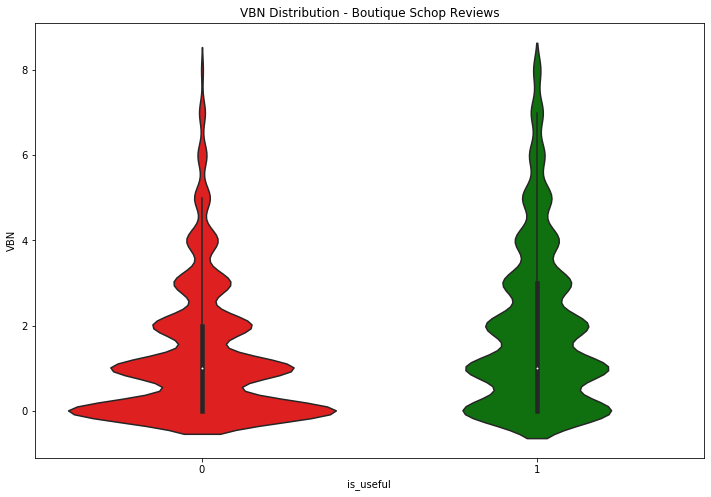

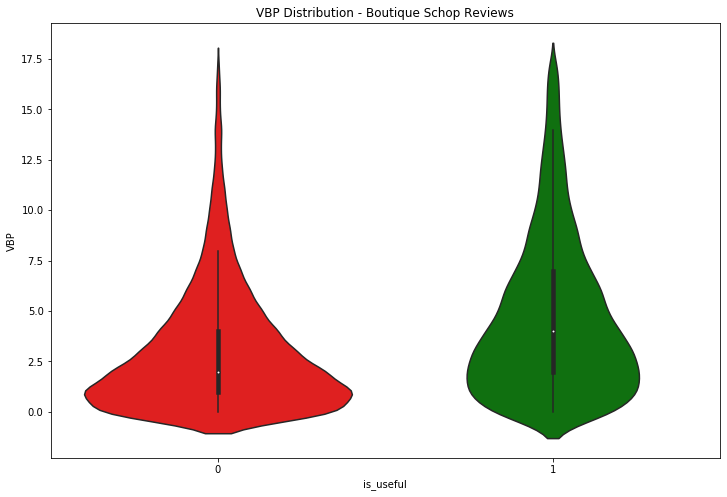

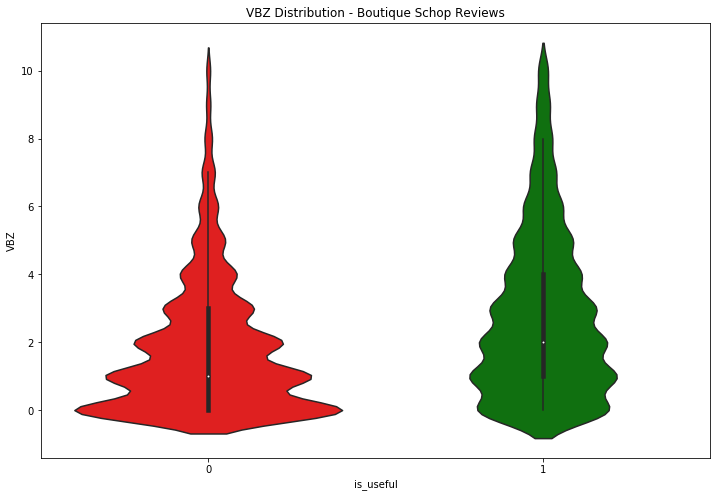

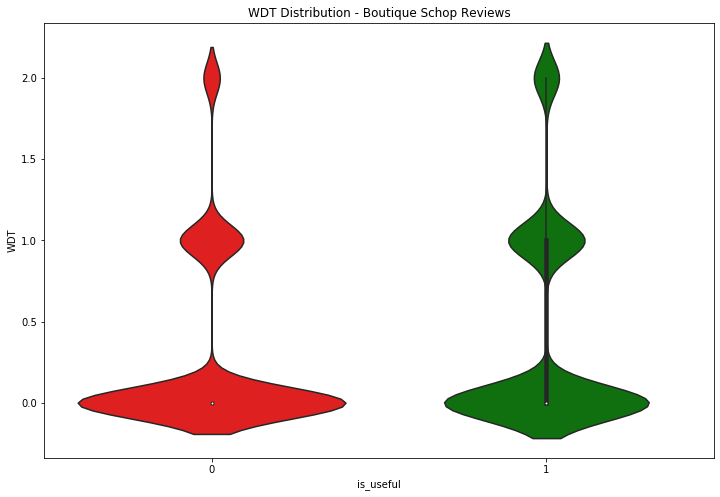

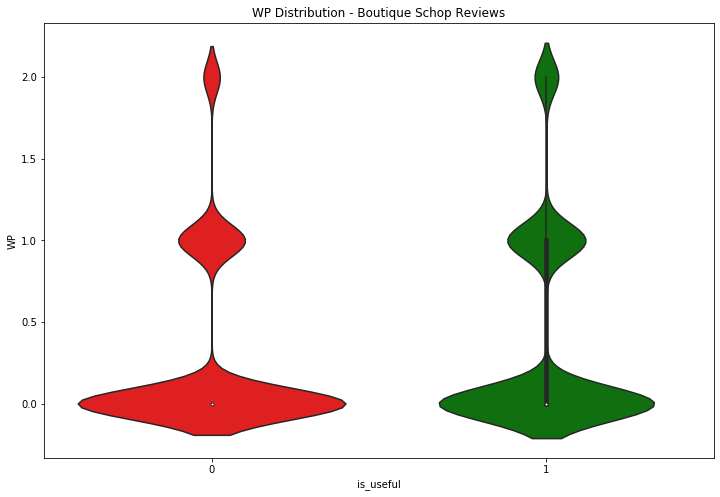

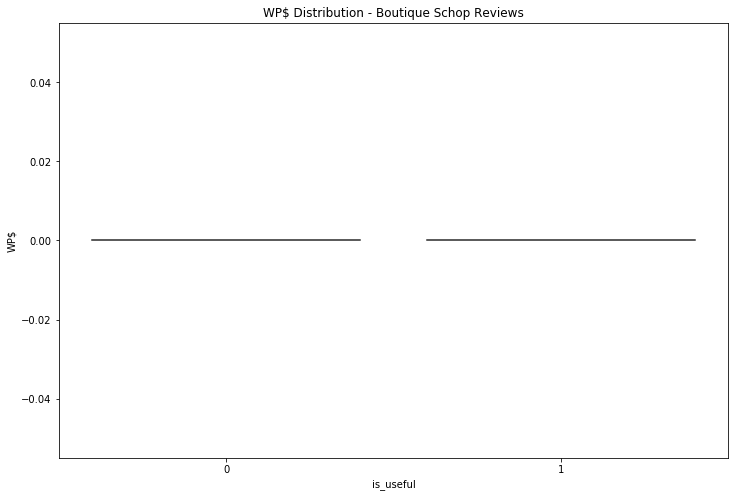

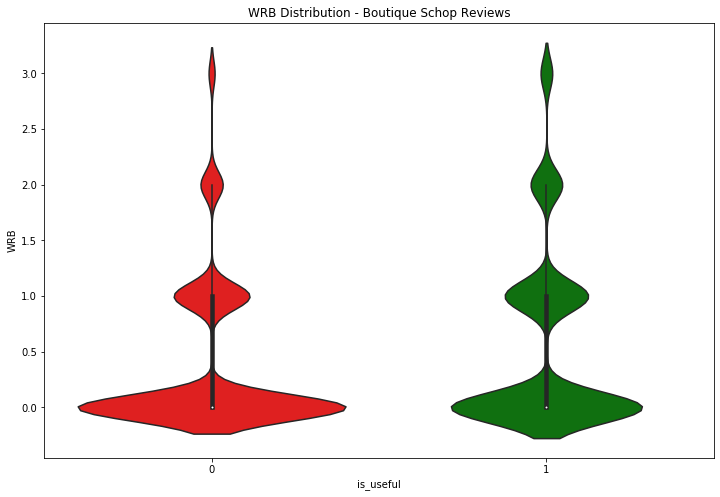

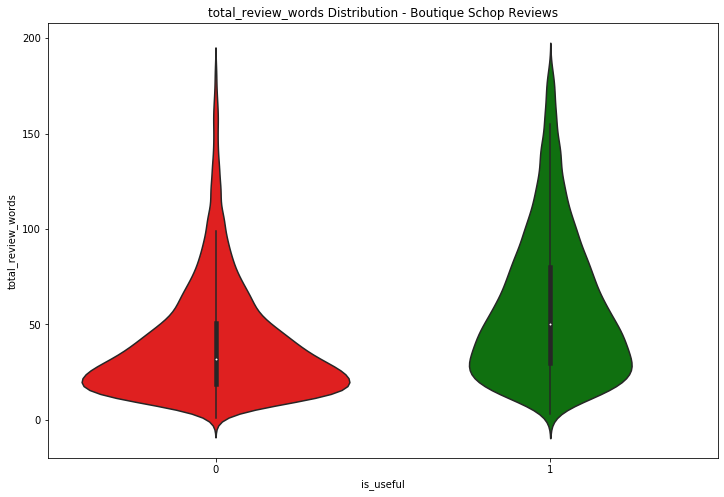

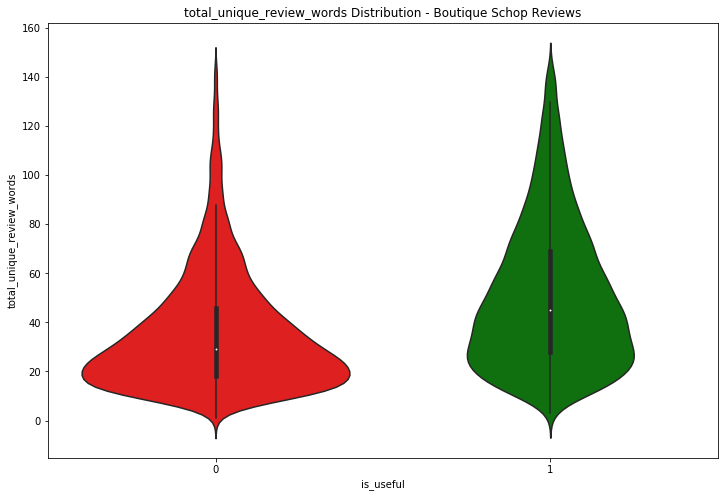

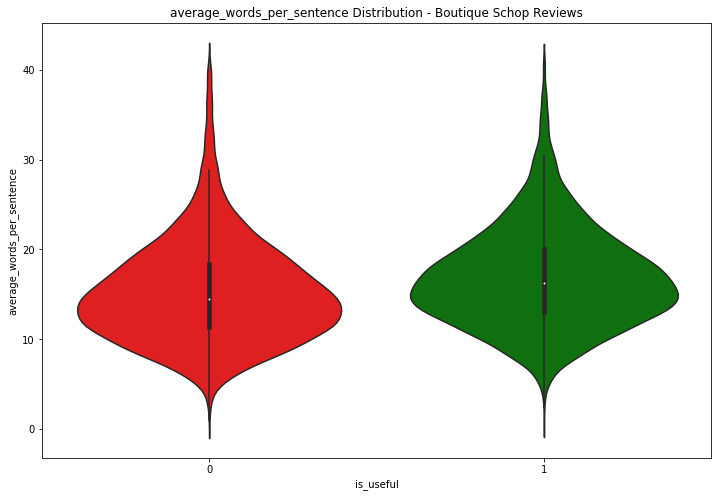

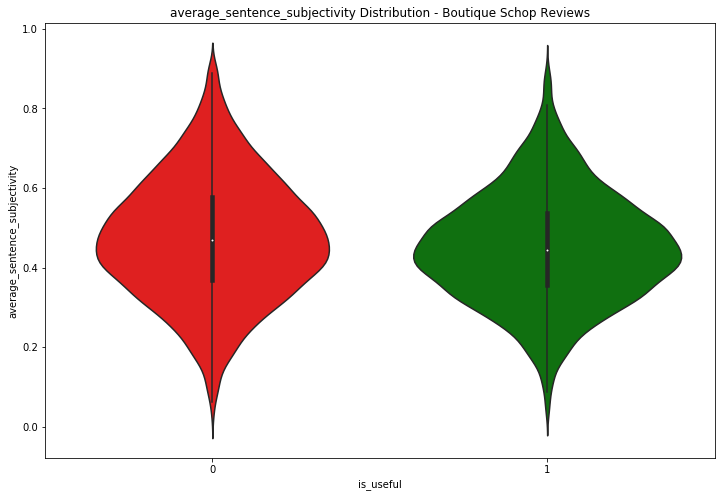

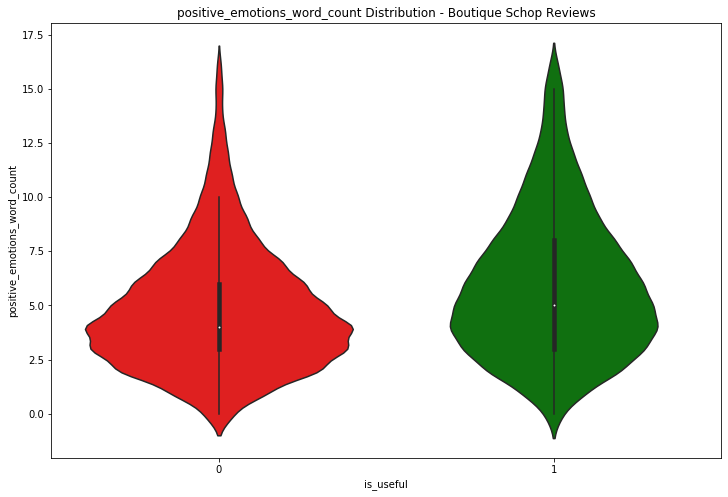

In [88]:
# now let's plot each continuous feature as a distribution
for feature in final_features:
    # create temp dataframe with just values less than three std from the mean
    temp_df = boutique_reviews_final[[feature, 'is_useful']]
    temp_df = temp_df[np.abs(temp_df[feature]-temp_df[feature].mean()) <= (3*temp_df[feature].std())]
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    p1=sns.violinplot(x="is_useful", y=feature, data=temp_df, palette = ['r', 'g'])
    plt.title("{} Distribution - Boutique Schop Reviews".format(feature))

Upon viewing the violin distributions, there are a few trends we can immediately make note of. 

1. Reviews classified as useful are in general much wordier - this is evident accross nearly as POS tag counts. With that said, the difference is more apparent in certain tags (i.e. IN, subordinating conjuctions) compared to others (i.e. PBR, comparative adverbs). 
2. Reviews with a higher "positive emotion" word count are generally viewed as more useful. 
3. Even though the difference is slight, it appears that useful reviews typically contain slightly more objective sentences. 

Before we begin modeling we will split our data into test and train sets. The test set will be our hold-out set and not touched until we are finished optimizing our models. The training set will be used for cross validation. 

In [89]:
# train-test split for coffee shops
X_train_coffee, X_test_coffee, y_train_coffee, y_test_coffee = train_test_split(coffee_features, coffee_useful, 
                                                                                test_size=0.20, random_state=42, 
                                                                                shuffle=True)

In [90]:
# train-test split for boutique shops
X_train_boutique, X_test_boutique, y_train_boutique, y_test_boutique = train_test_split(boutique_features, boutique_useful, 
                                                                                        test_size=0.20, random_state=42,
                                                                                        shuffle=True)

Finally, we will scale our training and validation data. 

In [91]:
# initialize standardscaler(); make sure to fit_transform train and val sets separately to prevent data leakage
scaler = StandardScaler()

X_train_scaled_coffee = scaler.fit_transform(X_train_coffee)
X_test_scaled_coffee = scaler.fit_transform(X_test_coffee)

X_train_scaled_boutique = scaler.fit_transform(X_train_boutique)
X_test_scaled_boutique = scaler.fit_transform(X_test_boutique)

# Initial Classification Model: Logistic Regression

## Tuned Logistic Regression: Grid Search and Cross Validation Pipeline

### Coffee Shop Reviews

In [92]:
# initialize logistic regression pipeline
logreg_pipeline_coffee = Pipeline([('logreg', LogisticRegression(solver='liblinear', random_state=42))])

# define grid parameters
logreg_grid_coffee = [{'logreg__C': [0.000001, 0.001, 1]}]

# initialize grid object
logreg_gridsearch_coffee = GridSearchCV(estimator=logreg_pipeline_coffee,
                                        param_grid=logreg_grid_coffee, 
                                        scoring='roc_auc',
                                        cv=5)

# fit to train data
logreg_gridsearch_coffee.fit(X_train_scaled_coffee, y_train_coffee)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=42,
                                                

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Tuned Logistic Regression Classifier Training Data Scores

Recall Score: 41.291%
Precision Score: 66.646%
Accuracy Score: 65.278%
F1 Score: 0.5099
ROC AUC Score: 0.62611

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


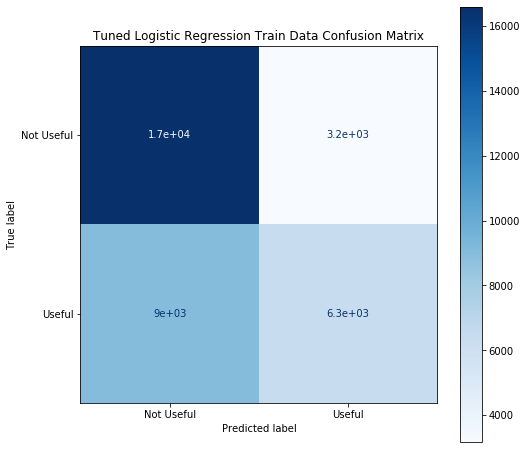


Train Data ROC Curve
---------------------------------------------------------------------------------------


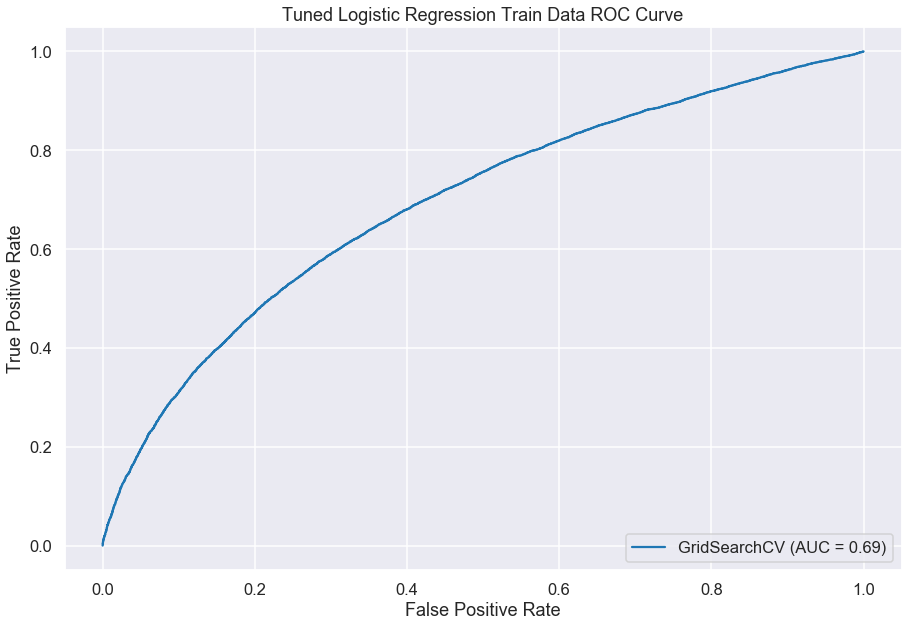


TESTING SET METRICS
--------------------------------------------------------------------------------------
Tuned Logistic Regression Classifier Testing Data Scores

Recall Score: 40.543%
Precision Score: 65.154%
Accuracy Score: 65.323%
F1 Score: 0.49984
ROC AUC Score: 0.6218

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


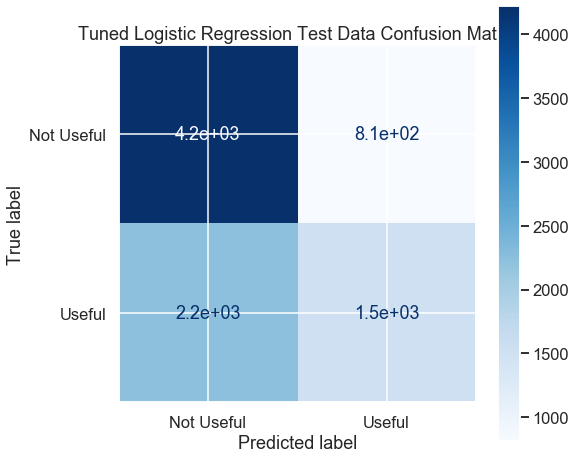


Test Data ROC Curve
---------------------------------------------------------------------------------------


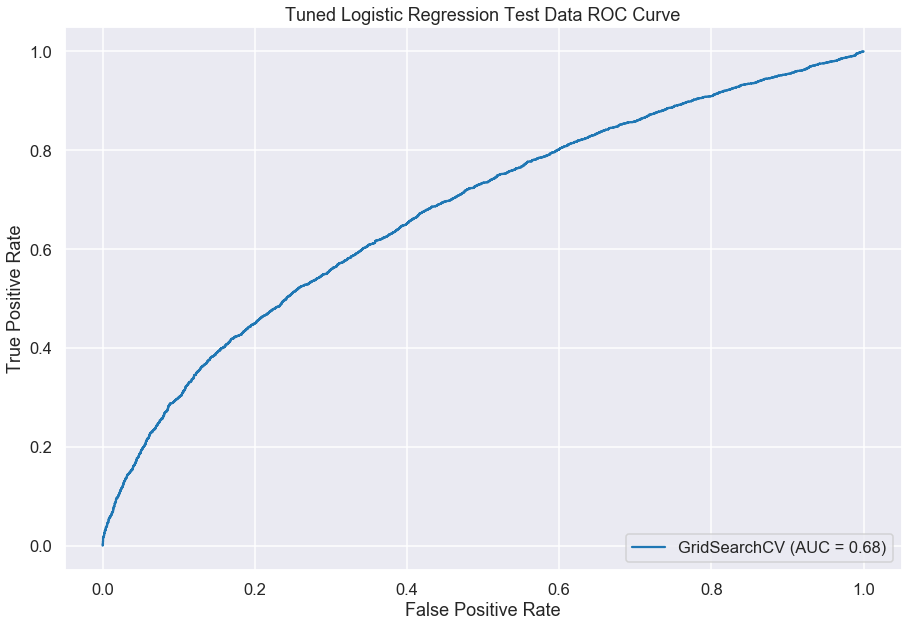

In [93]:
# evaluate grid search model
binary_classification_evaluation(logreg_gridsearch_coffee, X_train_scaled_coffee, y_train_coffee, 
                                 name_of_estimator="Tuned Logistic Regression", cm_labels=['Not Useful', 'Useful'], 
                                 is_ANN=False)

In [94]:
# save gridsearch model
joblib.dump(logreg_gridsearch_coffee, 'logreg_gridsearch_coffee.pkl')

['logreg_gridsearch_coffee.pkl']

In [95]:
# check best model
logreg_gridsearch_coffee.best_estimator_

Pipeline(memory=None,
         steps=[('logreg',
                 LogisticRegression(C=0.001, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### Boutique Shop Reviews

In [96]:
# initialize logistic regression pipeline
logreg_pipeline_boutique = Pipeline([('logreg', LogisticRegression(solver='liblinear', random_state=42))])

# define grid parameters
logreg_grid_boutique = [{'logreg__C': [0.001, 1, 1000]}]

# initialize grid object
logreg_gridsearch_boutique = GridSearchCV(estimator=logreg_pipeline_boutique,
                                 param_grid=logreg_grid_boutique, 
                                 scoring='roc_auc',
                                 cv=4)

# fit to train data
logreg_gridsearch_boutique.fit(X_train_scaled_boutique, y_train_boutique)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=42,
                                                

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Tuned Logistic Regression Classifier Training Data Scores

Recall Score: 65.696%
Precision Score: 66.695%
Accuracy Score: 63.24%
F1 Score: 0.66192
ROC AUC Score: 0.62981

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


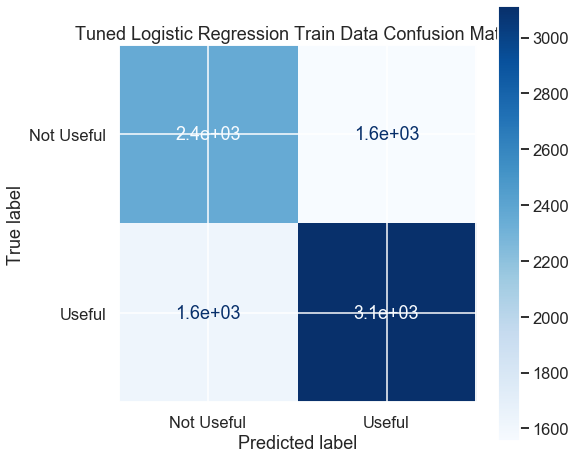


Train Data ROC Curve
---------------------------------------------------------------------------------------


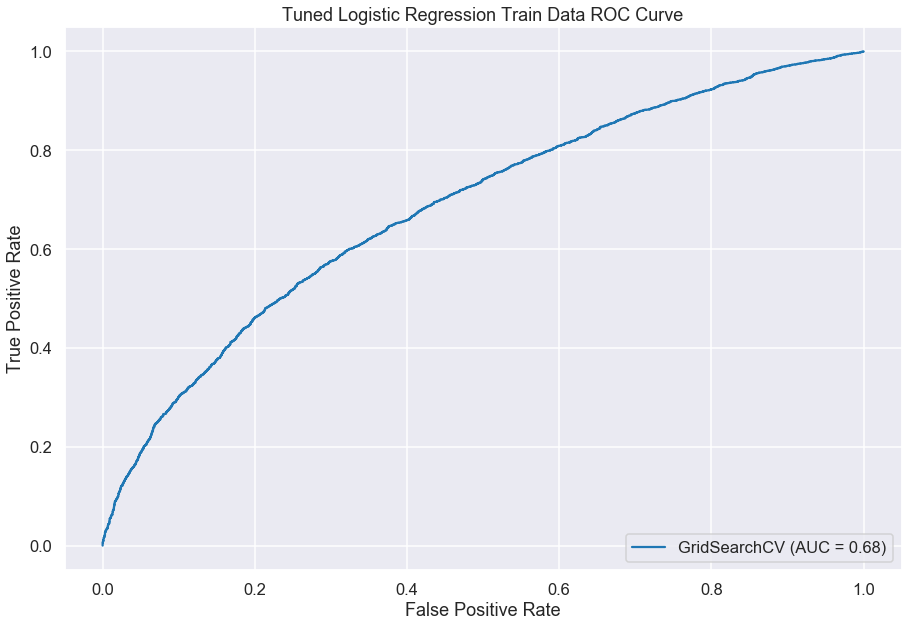


TESTING SET METRICS
--------------------------------------------------------------------------------------
Tuned Logistic Regression Classifier Testing Data Scores

Recall Score: 69.737%
Precision Score: 70.962%
Accuracy Score: 66.944%
F1 Score: 0.70344
ROC AUC Score: 0.66547

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


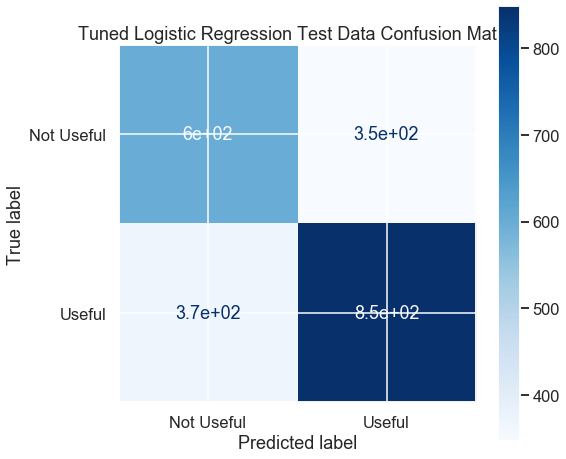


Test Data ROC Curve
---------------------------------------------------------------------------------------


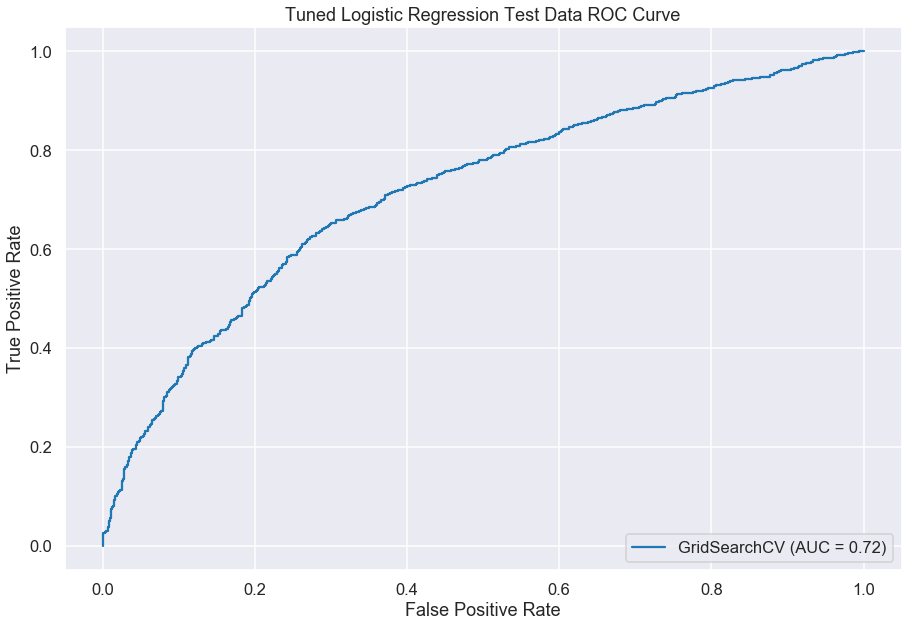

In [97]:
# evaluate grid search model
binary_classification_evaluation(logreg_gridsearch_boutique, X_train_scaled_boutique, y_train_boutique,
                                 name_of_estimator="Tuned Logistic Regression",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [98]:
# save gridsearch model
joblib.dump(logreg_gridsearch_boutique, 'logreg_gridsearch_boutique.pkl') 

['logreg_gridsearch_boutique.pkl']

In [99]:
# check best model
logreg_gridsearch_boutique.best_estimator_

Pipeline(memory=None,
         steps=[('logreg',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## Embedded Feature Selection

In [100]:
sorted(abs(logreg_gridsearch_coffee.best_estimator_[0].coef_[0]))

[6.150893650001852e-07,
 0.0005466915794331699,
 0.0009328002582223811,
 0.0015127094465666989,
 0.003418898585424435,
 0.004459642936594555,
 0.004717751855744948,
 0.0049110312305526435,
 0.00502407193614604,
 0.007880846818022933,
 0.00854430828554132,
 0.009086532218935737,
 0.010077998282054903,
 0.01119368673291257,
 0.01169916376189066,
 0.013691299283033092,
 0.014413920837133234,
 0.014875688187795277,
 0.015415150227538,
 0.015487824720137697,
 0.019804464862706667,
 0.02275230212030025,
 0.022961921927181494,
 0.023406283397065773,
 0.02582279548533295,
 0.031120230448620223,
 0.032285112237666544,
 0.034016442579090686,
 0.03475543806325403,
 0.03833195186367951,
 0.046583034927583755,
 0.04856092996415148,
 0.05830461521589964,
 0.06591818718981236,
 0.06791929781193373,
 0.07301078716120352,
 0.0759104575236231,
 0.0772389424773276,
 0.10991810254244767,
 0.15469966577404773,
 0.16679070877645658]

In [101]:
# create list of 
most_important_features = X_train_coffee.columns[(logreg_gridsearch_coffee.best_estimator_[0].coef_ > .05).ravel().tolist()]
most_important_features

Index(['DT', 'IN', 'JJ', 'NN', 'NNP', 'total_unique_review_words',
       'positive_emotions_word_count'],
      dtype='object')

In [102]:
sorted(abs(logreg_gridsearch_boutique.best_estimator_[0].coef_[0]))

[0.0043211572725473735,
 0.0051871568508519515,
 0.0061510511276091865,
 0.008154480911699184,
 0.009574038193624691,
 0.010420001481660692,
 0.01240054660257325,
 0.01730029939326987,
 0.018250103690439282,
 0.021144424892356063,
 0.024203817110618826,
 0.024544409372671407,
 0.02470616888406108,
 0.02949969955264461,
 0.03353229468772423,
 0.0401586326909629,
 0.04128531118526736,
 0.04412691233448468,
 0.04699957797731131,
 0.04954095192032746,
 0.050320998106082065,
 0.05253853123859935,
 0.05747018184145408,
 0.06005423777908107,
 0.060983262397974566,
 0.06158824019758122,
 0.06405923112321832,
 0.07048126610125738,
 0.0706576340162143,
 0.07307077574014928,
 0.08078963362259738,
 0.08775465481463467,
 0.08980555571355463,
 0.10207540834014195,
 0.10251737973185547,
 0.1322662968092357,
 0.17214385323268022,
 0.17814780403002967,
 0.24799832238284625,
 0.34160593504781284,
 1.0488156764641205]

In [103]:
most_important_features = X_train_boutique.columns[(logreg_gridsearch_boutique.best_estimator_[0].coef_ > .05).ravel().tolist()]
most_important_features

Index(['DT', 'JJ', 'LS', 'NNS', 'NNP', 'PRP', 'RP', 'UH', 'VBZ',
       'total_unique_review_words'],
      dtype='object')

Baseed on our logistic regression coefficients it appears that the most important features in determining the usefulness of a review are positive emotions word count, total unique review words, and the parts-of-speech counts specifically for determiners (DT), adjectives (JJ), and, surprisingly, the presense of proper nouns (NNP).

# Decision Tree and Ensemble Methods

## Tuned Decision Tree

### Coffee Reviews

In [104]:
# initialize decision tree pipeline
dt_pipeline_coffee = Pipeline([('dt', DecisionTreeClassifier(criterion='entropy', random_state=42))])

# define grid parameters
dt_grid = [{'dt__max_depth': [3, 5, 7]},
           {'dt__min_samples_split': [2]},
           {'dt__min_samples_leaf': [1, 2]}]

# initialize grid object
dt_gridsearch_coffee = GridSearchCV(estimator=dt_pipeline_coffee,
                                    param_grid=dt_grid,
                                    scoring='roc_auc',
                                    cv=5)

# fit to train data
dt_gridsearch_coffee.fit(X_train_scaled_coffee, y_train_coffee)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='entropy',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                       

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Pruned Decision Tree Classifier Training Data Scores

Recall Score: 48.39%
Precision Score: 64.535%
Accuracy Score: 65.79%
F1 Score: 0.55308
ROC AUC Score: 0.63855

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


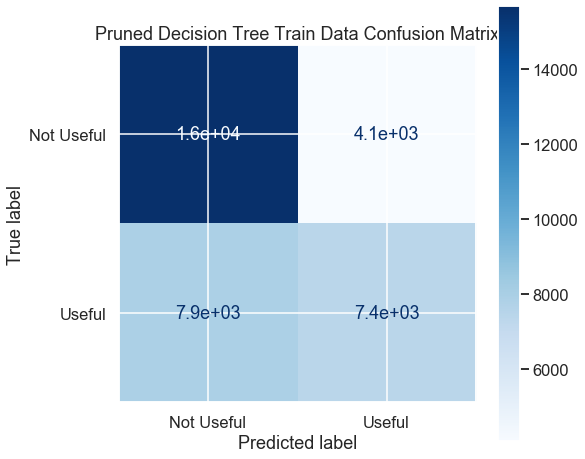


Train Data ROC Curve
---------------------------------------------------------------------------------------


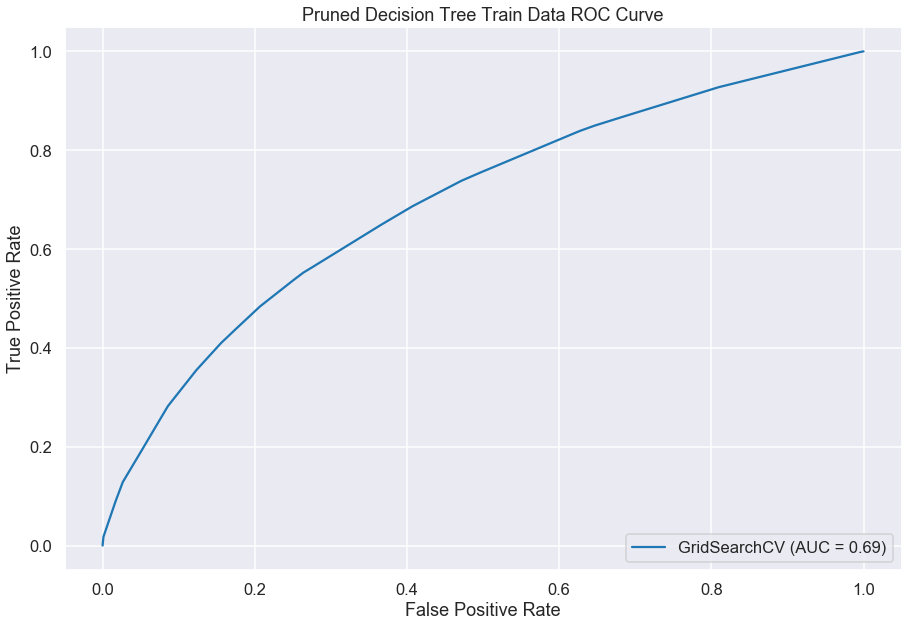


TESTING SET METRICS
--------------------------------------------------------------------------------------
Pruned Decision Tree Classifier Testing Data Scores

Recall Score: 46.883%
Precision Score: 62.191%
Accuracy Score: 65.118%
F1 Score: 0.53463
ROC AUC Score: 0.62805

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


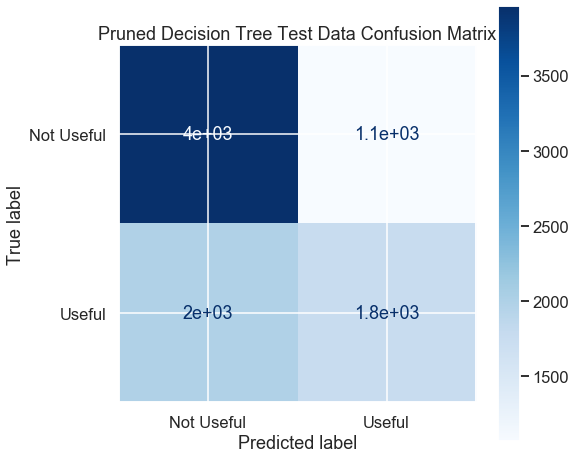


Test Data ROC Curve
---------------------------------------------------------------------------------------


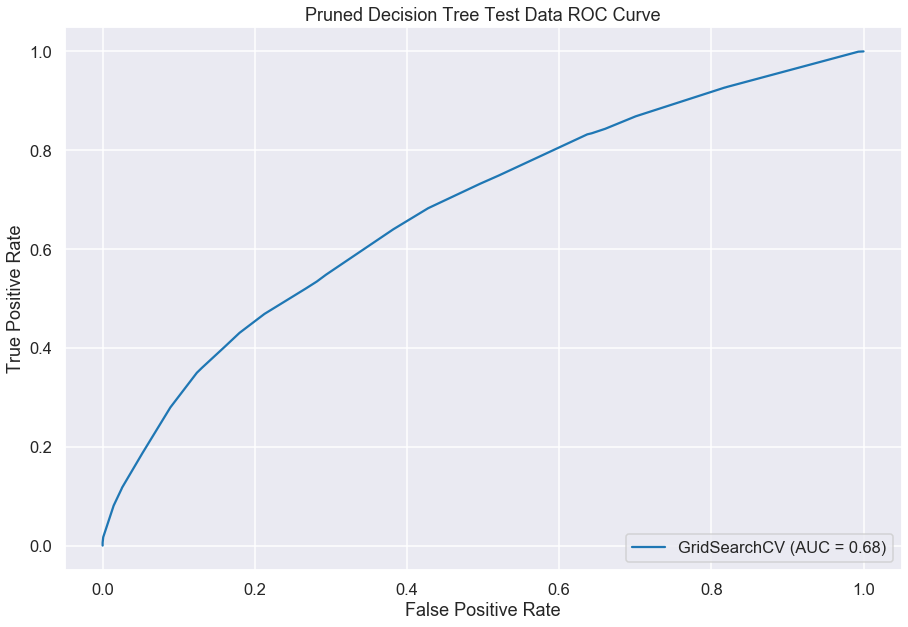

In [105]:
# evaluate grid search model
binary_classification_evaluation(dt_gridsearch_coffee, X_train_scaled_coffee, y_train_coffee,
                                 name_of_estimator="Pruned Decision Tree",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [106]:
# save gridsearch model
joblib.dump(dt_gridsearch_coffee, 'dt_gridsearch_coffee.pkl') 

['dt_gridsearch_coffee.pkl']

In [107]:
# check best model
dt_gridsearch_coffee.best_estimator_

Pipeline(memory=None,
         steps=[('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=42,
                                        splitter='best'))],
         verbose=False)

### Boutique Reviews

In [108]:
# initialize decision tree pipeline
dt_pipeline_boutique = Pipeline([('dt', DecisionTreeClassifier(criterion='entropy', random_state=42))])

# define grid parameters
dt_grid = [{'dt__max_depth': [5, 20, None]},
           {'dt__min_samples_split': [2]},
           {'dt__min_samples_leaf': [2, 4, 8]}]

# initialize grid object
dt_gridsearch_boutique = GridSearchCV(estimator=dt_pipeline_boutique,
                                    param_grid=dt_grid,
                                    scoring='roc_auc',
                                    cv=5)

# fit to train data
dt_gridsearch_boutique.fit(X_train_scaled_boutique, y_train_boutique)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='entropy',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                       

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Pruned Decision Tree Classifier Training Data Scores

Recall Score: 72.641%
Precision Score: 65.618%
Accuracy Score: 64.165%
F1 Score: 0.68951
ROC AUC Score: 0.6327

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


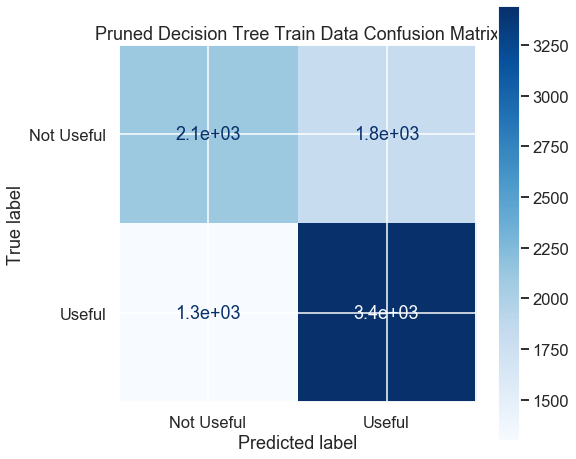


Train Data ROC Curve
---------------------------------------------------------------------------------------


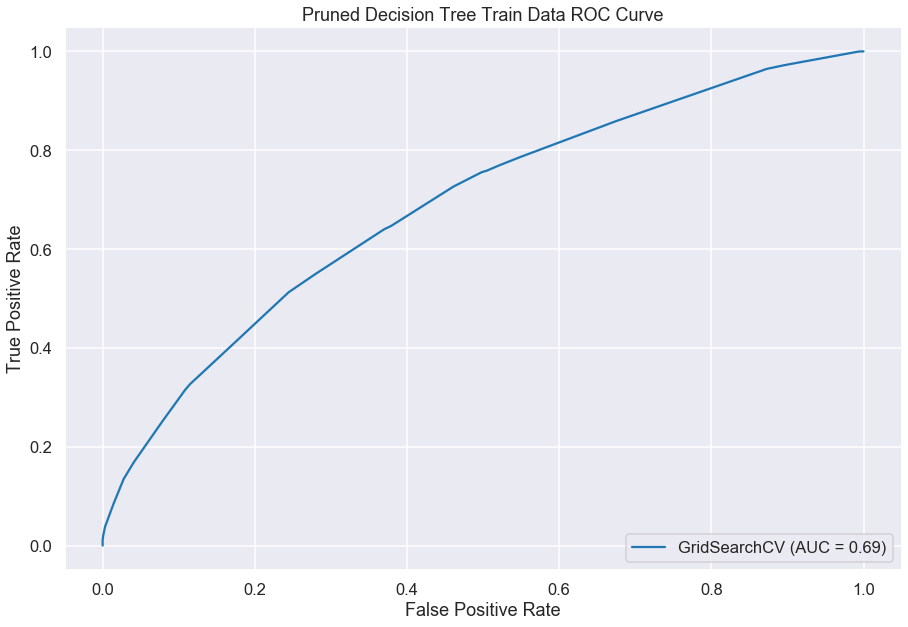


TESTING SET METRICS
--------------------------------------------------------------------------------------
Pruned Decision Tree Classifier Testing Data Scores

Recall Score: 75.329%
Precision Score: 67.701%
Accuracy Score: 65.927%
F1 Score: 0.71312
ROC AUC Score: 0.64592

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


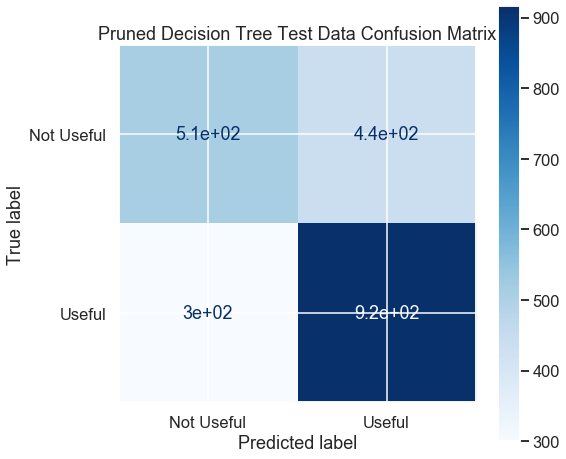


Test Data ROC Curve
---------------------------------------------------------------------------------------


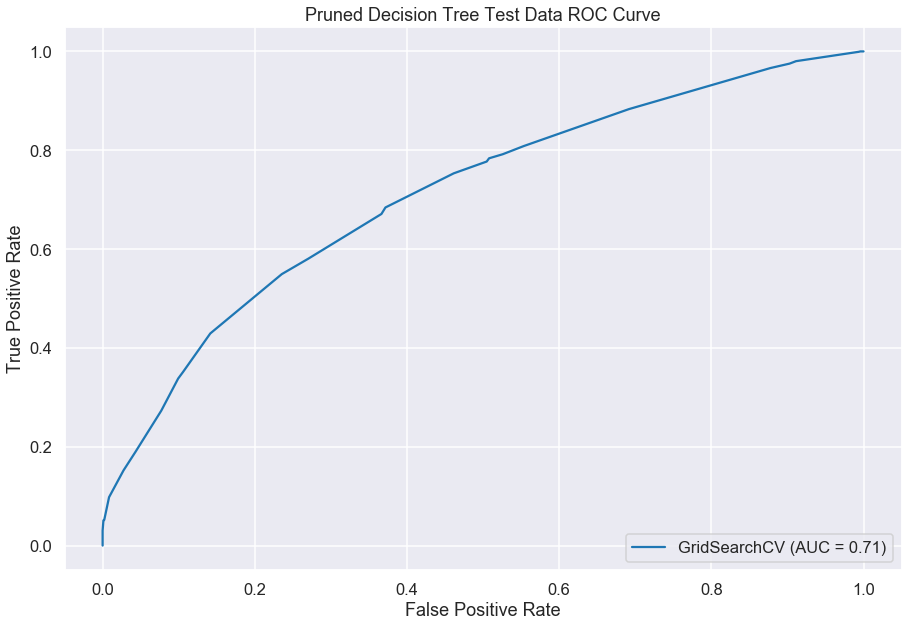

In [109]:
# evaluate grid search model
binary_classification_evaluation(dt_gridsearch_boutique, X_train_scaled_boutique, y_train_boutique,
                                 name_of_estimator="Pruned Decision Tree",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [110]:
# save gridsearch model
joblib.dump(dt_gridsearch_boutique, 'dt_gridsearch_boutique.pkl') 

['dt_gridsearch_boutique.pkl']

In [111]:
# check best model
dt_gridsearch_boutique.best_estimator_

Pipeline(memory=None,
         steps=[('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=42,
                                        splitter='best'))],
         verbose=False)

## Tuned Random Forest

We will now attempt an ensemble method using a random forest with 1000 trees. We will use a max depth of five for our trees as that is what performed the best when training our decision trees. 

### Coffee Reviews

In [112]:
# initialize random forest pipeline
forest_pipeline_coffee = Pipeline([('forest', RandomForestClassifier(criterion='entropy', random_state=42))])

# define grid parameters
forest_grid = [{'forest__n_estimators': [1000]},
               {'forest__max_depth': [5]},
               {'forest__min_samples_split': [2]},
               {'forest__min_samples_leaf': [1]}]

# initialize grid object
forest_gridsearch_coffee = GridSearchCV(estimator=forest_pipeline_coffee,
                                        param_grid=forest_grid,
                                        scoring='roc_auc',
                                        cv=5)

# fit to train data
forest_gridsearch_coffee.fit(X_train_scaled_coffee, y_train_coffee)

KeyboardInterrupt: 

In [ ]:
# evaluate grid search model
binary_classification_evaluation(forest_gridsearch_coffee, X_train_scaled_coffee, y_train_coffee,
                                 name_of_estimator="Pruned Random Forest",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [ ]:
# save gridsearch model
joblib.dump(forest_gridsearch_coffee, 'forest_gridsearch_coffee.pkl') 

In [ ]:
# check best model
forest_gridsearch_coffee.best_estimator_

#### Feature Importance

In [ ]:
# fit select from model instance to train data
sel = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=42))
sel.fit(X_train_scaled_coffee, y_train_coffee)

In [ ]:
# now we may use the get_support method to see which features are important
sel.get_support()

In [ ]:
# finally let's take a look at these
selected_feat = X_train_coffee.columns[(sel.get_support())]
print("Number of selected features: {}".format(len(selected_feat)))
print(selected_feat)

### Boutique Reviews

In [ ]:
# initialize random forest pipeline
forest_pipeline_boutique = Pipeline([('forest', RandomForestClassifier(criterion='entropy', random_state=42))])

# define grid parameters
forest_grid = [{'forest__n_estimators': [1000]},
               {'forest__max_depth': [5]},
               {'forest__min_samples_split': [2]},
               {'forest__min_samples_leaf': [1]}]

# initialize grid object
forest_gridsearch_boutique = GridSearchCV(estimator=forest_pipeline_boutique,
                                          param_grid=forest_grid,
                                          scoring='roc_auc',
                                          cv=5)

# fit to train data
forest_gridsearch_boutique.fit(X_train_scaled_boutique, y_train_boutique)

In [ ]:
# evaluate grid search model
binary_classification_evaluation(forest_gridsearch_boutique, X_train_scaled_boutique, y_train_boutique,
                                 name_of_estimator="Pruned Random Forest",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [ ]:
# save gridsearch model
joblib.dump(forest_gridsearch_boutique, 'forest_gridsearch_boutique.pkl') 

In [ ]:
# check best model
forest_gridsearch_boutique.best_estimator_

## Tuned XGBoost

### Coffee Reviews

In [ ]:
# initialize forest pipeline
xgb_pipeline_coffee = Pipeline([('xgb', xgb.XGBClassifier(random_state=42))])

# define grid parameters
xgb_grid = [{'xgb__n_estimators': [500]},
            {'xgb__learning_rate': [0.1]},
            # already tested max_depth, min_child_weight, subsample
            {'xgb__max_depth': [3]},
            {'xgb__min_child_weight': [1]},
            {'xgb__subsample': [1]}]

# initialize grid object
xgb_gridsearch_coffee = GridSearchCV(estimator=xgb_pipeline_coffee,
                                     param_grid=xgb_grid,
                                     scoring='roc_auc',
                                     cv=4)

# fit to train data
xgb_gridsearch_coffee.fit(X_train_scaled_coffee, y_train_coffee)

In [ ]:
binary_classification_evaluation(xgb_gridsearch_coffee, X_train_scaled_coffee, y_train_coffee, 
                                 name_of_estimator="Tuned XGBoost Classifier",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [ ]:
# save gridsearch model
joblib.dump(xgb_gridsearch_coffee, 'xgb_gridsearch.pkl') 

In [ ]:
# show best estimator
xgb_gridsearch_coffee.best_estimator_

### Boutique Reviews

In [ ]:
# initialize forest pipeline
xgb_pipeline_boutique = Pipeline([('xgb', xgb.XGBClassifier(random_state=42))])

# define grid parameters
xgb_grid = [{'xgb__n_estimators': [500]},
            {'xgb__learning_rate': [0.1]},
            # already tested max_depth, min_child_weight, subsample
            {'xgb__max_depth': [3]},
            {'xgb__min_child_weight': [1]},
            {'xgb__subsample': [1]}]

# initialize grid object
xgb_gridsearch_boutique = GridSearchCV(estimator=xgb_pipeline_boutique,
                                     param_grid=xgb_grid,
                                     scoring='roc_auc',
                                     cv=4)

# fit to train data
xgb_gridsearch_boutique.fit(X_train_scaled_boutique, y_train_boutique)

In [ ]:
binary_classification_evaluation(xgb_gridsearch_boutique, X_train_scaled_boutique, y_train_boutique, 
                                 name_of_estimator="Tuned XGBoost Classifier",
                                 cm_labels=['Not Useful', 'Useful'], is_ANN=False)

In [ ]:
# save gridsearch model
joblib.dump(xgb_gridsearch_boutique, 'xgb_gridsearch_boutique.pkl') 

In [ ]:
# show best estimator
xgb_gridsearch_boutique.best_estimator_

# Model Analysis - Test Set

In [ ]:
y_hat = np.round(forest_gridsearch_coffee.predict(X_test_scaled_coffee),0)
print("{} Model Performance")
print("--------------------------------------------")
print("Recall Score: {}".format(recall_score(y_test_coffee, y_hat)))
print("Precision Score: {}".format(precision_score(y_test_coffee, y_hat)))
print("Accuracy Score: {}".format(accuracy_score(y_test_coffee, y_hat)))
print("F1 Score: {}".format(f1_score(y_test_coffee, y_hat)))
print("ROC AUC Score: {}".format(roc_auc_score(y_test_coffee, y_hat)))